<h1> Spatial Clustering Insights from the 2023 City of Vancouver Property Tax Report </h1>

In [1]:
## Load Relevant Libraries 

# Tidyverse library used for wrangling and tidying data
library(tidyverse)

# Tidymodels library used for kmeans clustering
library(tidymodels)

# Broom used for tidy visualization of clustering
library(broom)

# ggpairs used to sort out which variables correlate strongly
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h1> 1. Data Specification </h1>
This project uses data from the City of Vancouver Open Data Portal 

In [2]:
#setting seed
set.seed(9876)
seed <- 9876

## 2023 CoV Property Tax Report Dataset imported by url (HTTP GET)
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   ZONING_CLASSIFICATION,
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   NEIGHBOURHOOD_CODE,
                   TAX_LEVY)

## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)

# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_parcel_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",") |>
# Convert (lat,long) into numeric data
            mutate(lat = as.double(lat)) |>
            mutate(long = as.double(long))

Rows: 220840 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100164 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
## Data Tidying
# Filter for housing properties only by zone
property_housing_only <- ptax_parcel_merged |>
    filter(ZONING_CLASSIFICATION == c("Comprehensive Development",
                                      # NOTE: Comprehensive Developments are mixed-use, and could look like an 
                                      # apartment building with shops below, or a shopping mall with a few apartments
                                      # above. This report acknowledges the limitations of this in further sections.
                                      "Single Detached House",
                                      "Multiple Dwelling"))

print(paste("Entry Count before NA and 0 removal: ", nrow(property_housing_only))) 
property_housing_only <- property_housing_only |>
                            drop_na()
print(paste("Entry Count after NA and 0 removal: ", nrow(property_housing_only)))

# Summary table counting each housing type
property_summ_table <- property_housing_only |>
    group_by(ZONING_CLASSIFICATION) |>
    summarize(COUNT = n())
property_summ_table

Warning message in ZONING_CLASSIFICATION == c("Comprehensive Development", "Single Detached House", :
“longer object length is not a multiple of shorter object length”


[1] "Entry Count before NA and 0 removal:  60865"
[1] "Entry Count after NA and 0 removal:  58988"


ZONING_CLASSIFICATION     COUNT
1 Comprehensive Development 26495
2 Multiple Dwelling         10387
3 Single Detached House     22106

<h1> 2. Calculating Spatial Centroids </h1>

This project will use the spatial centroids of properties within each neighbourhood coded in the Property Tax Report  as an external validation. The first set of centroids consist of those that take into consideration all types of properties within a neighbourhood, and the second set of centroids consist of those that only take the locations of strata housing into consideration.  

<h2> Neighbourhood Centroids using All Properties </h2>

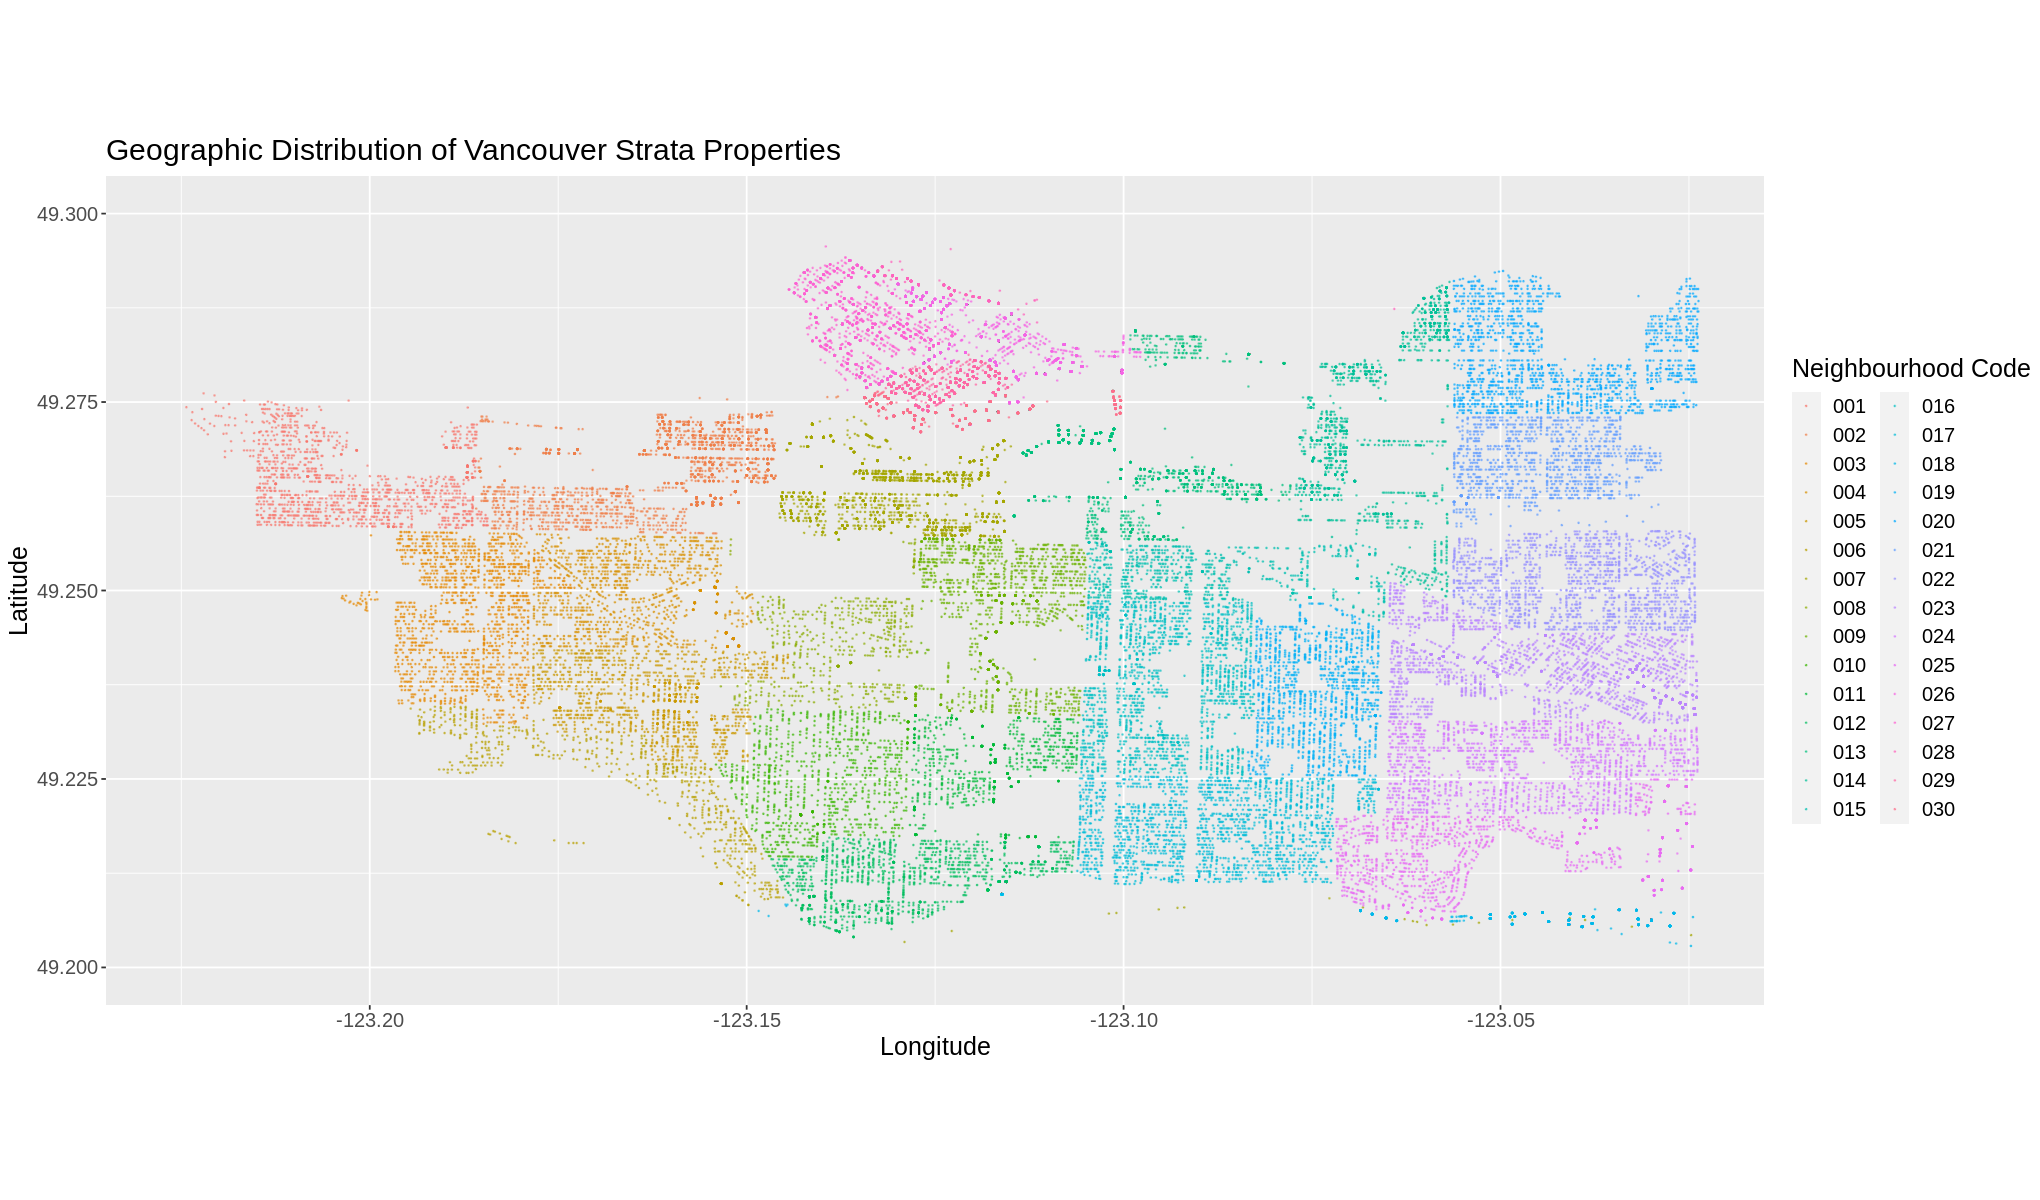

In [4]:
# This plot shows the spatial distribution of all properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
property_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
property_plot

<h2> Neighbourhood Centroids using Strata Properties Only </h2>

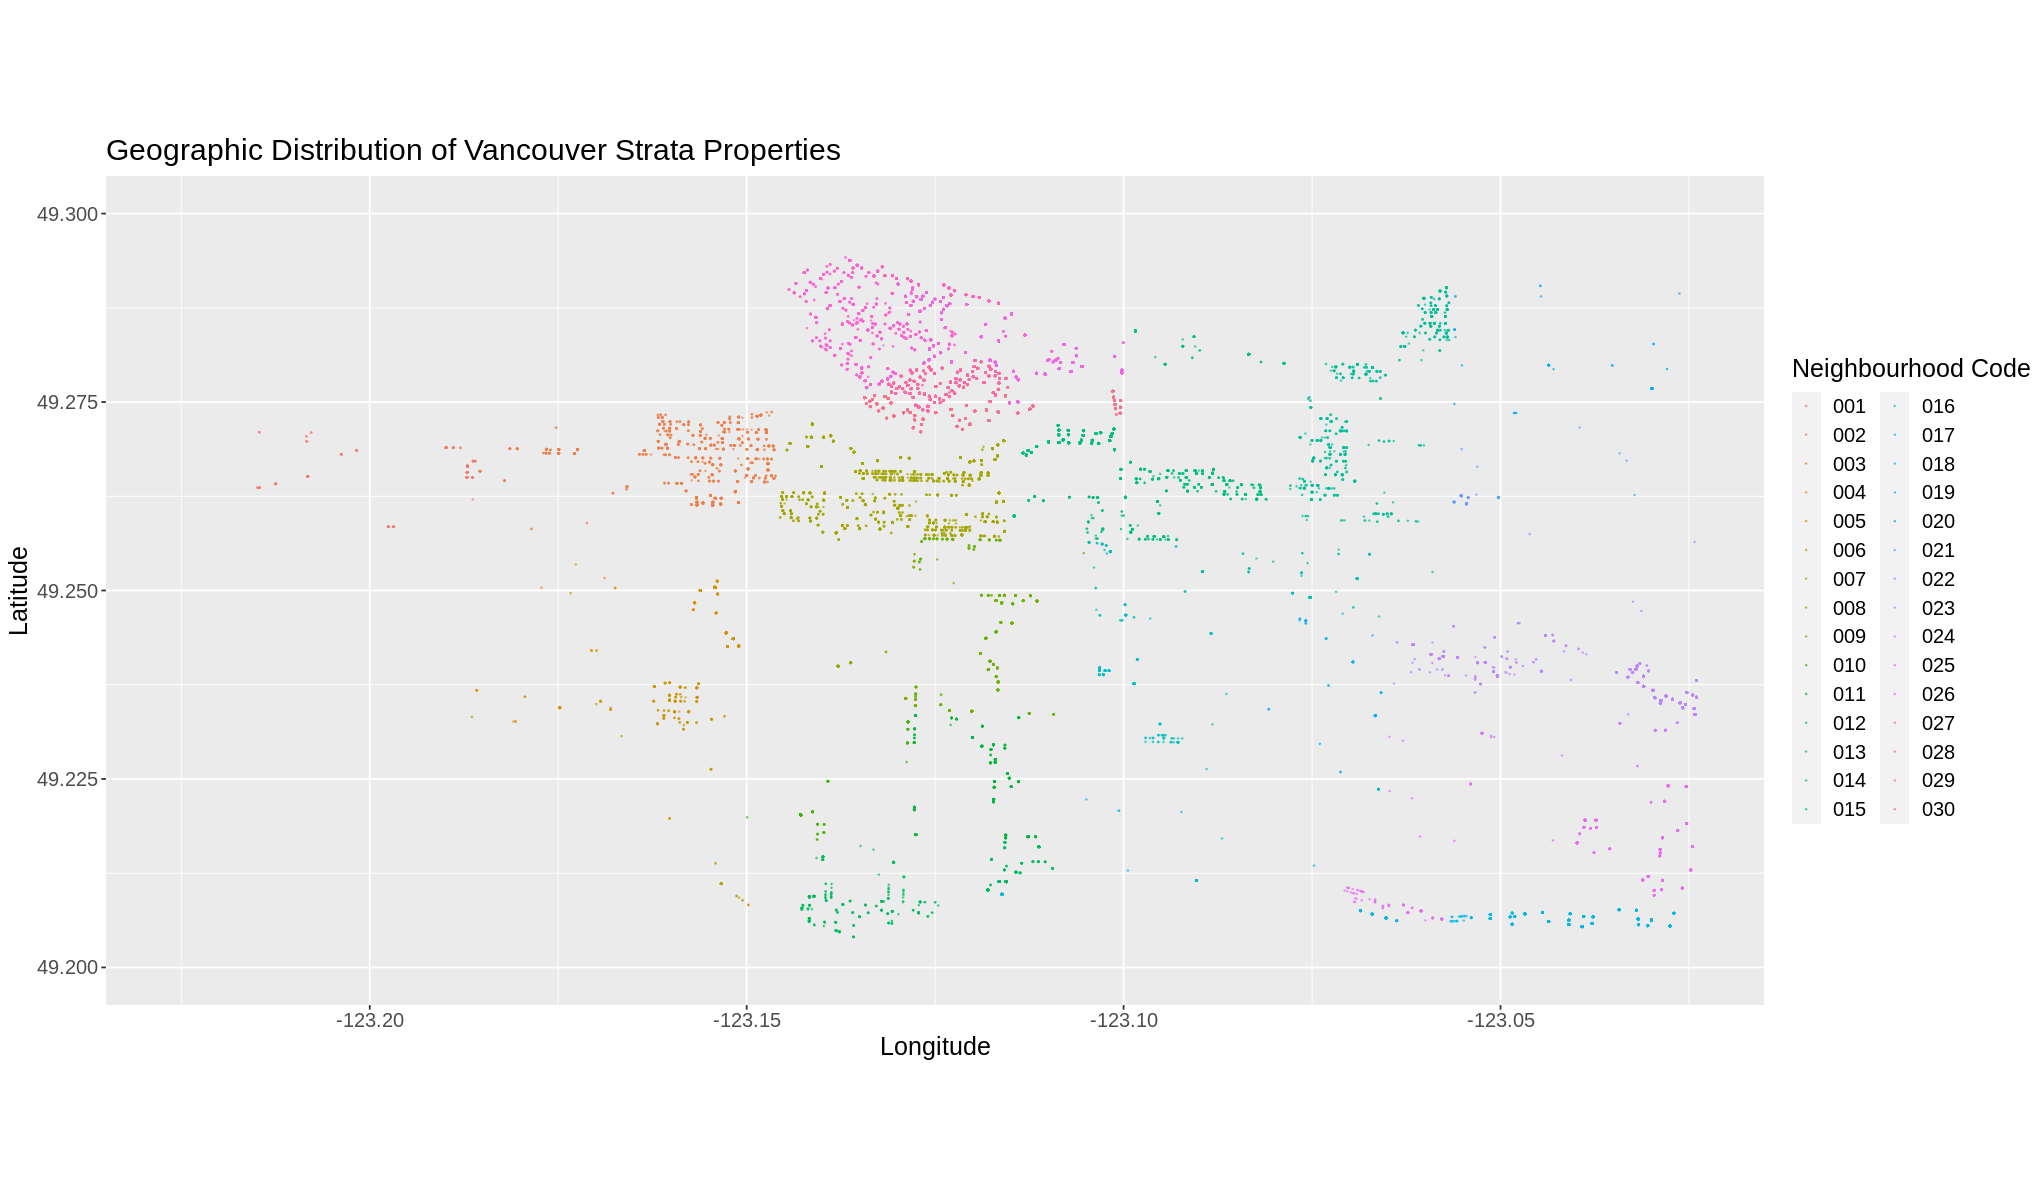

In [5]:
# This plot shows the spatial distribution of strata properties in Vancouver, coloured by neighbourhood
options(repr.plot.width = 17, repr.plot.height =10)
strata_only_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                filter(LEGAL_TYPE == "STRATA") |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE)) +
                geom_point(alpha = 0.5, size = 0.125) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     color = "Neighbourhood Code", 
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
strata_only_plot

In [11]:
# Strata Housing Centroids
# Group by, summarize, and plot




<h1> 3. Model Parameter Tuning </h1> 
The model will be tuned a priori using the elbow plot method, and will qualitively compare the results using the calculated spatial centroids from Section 3 above.

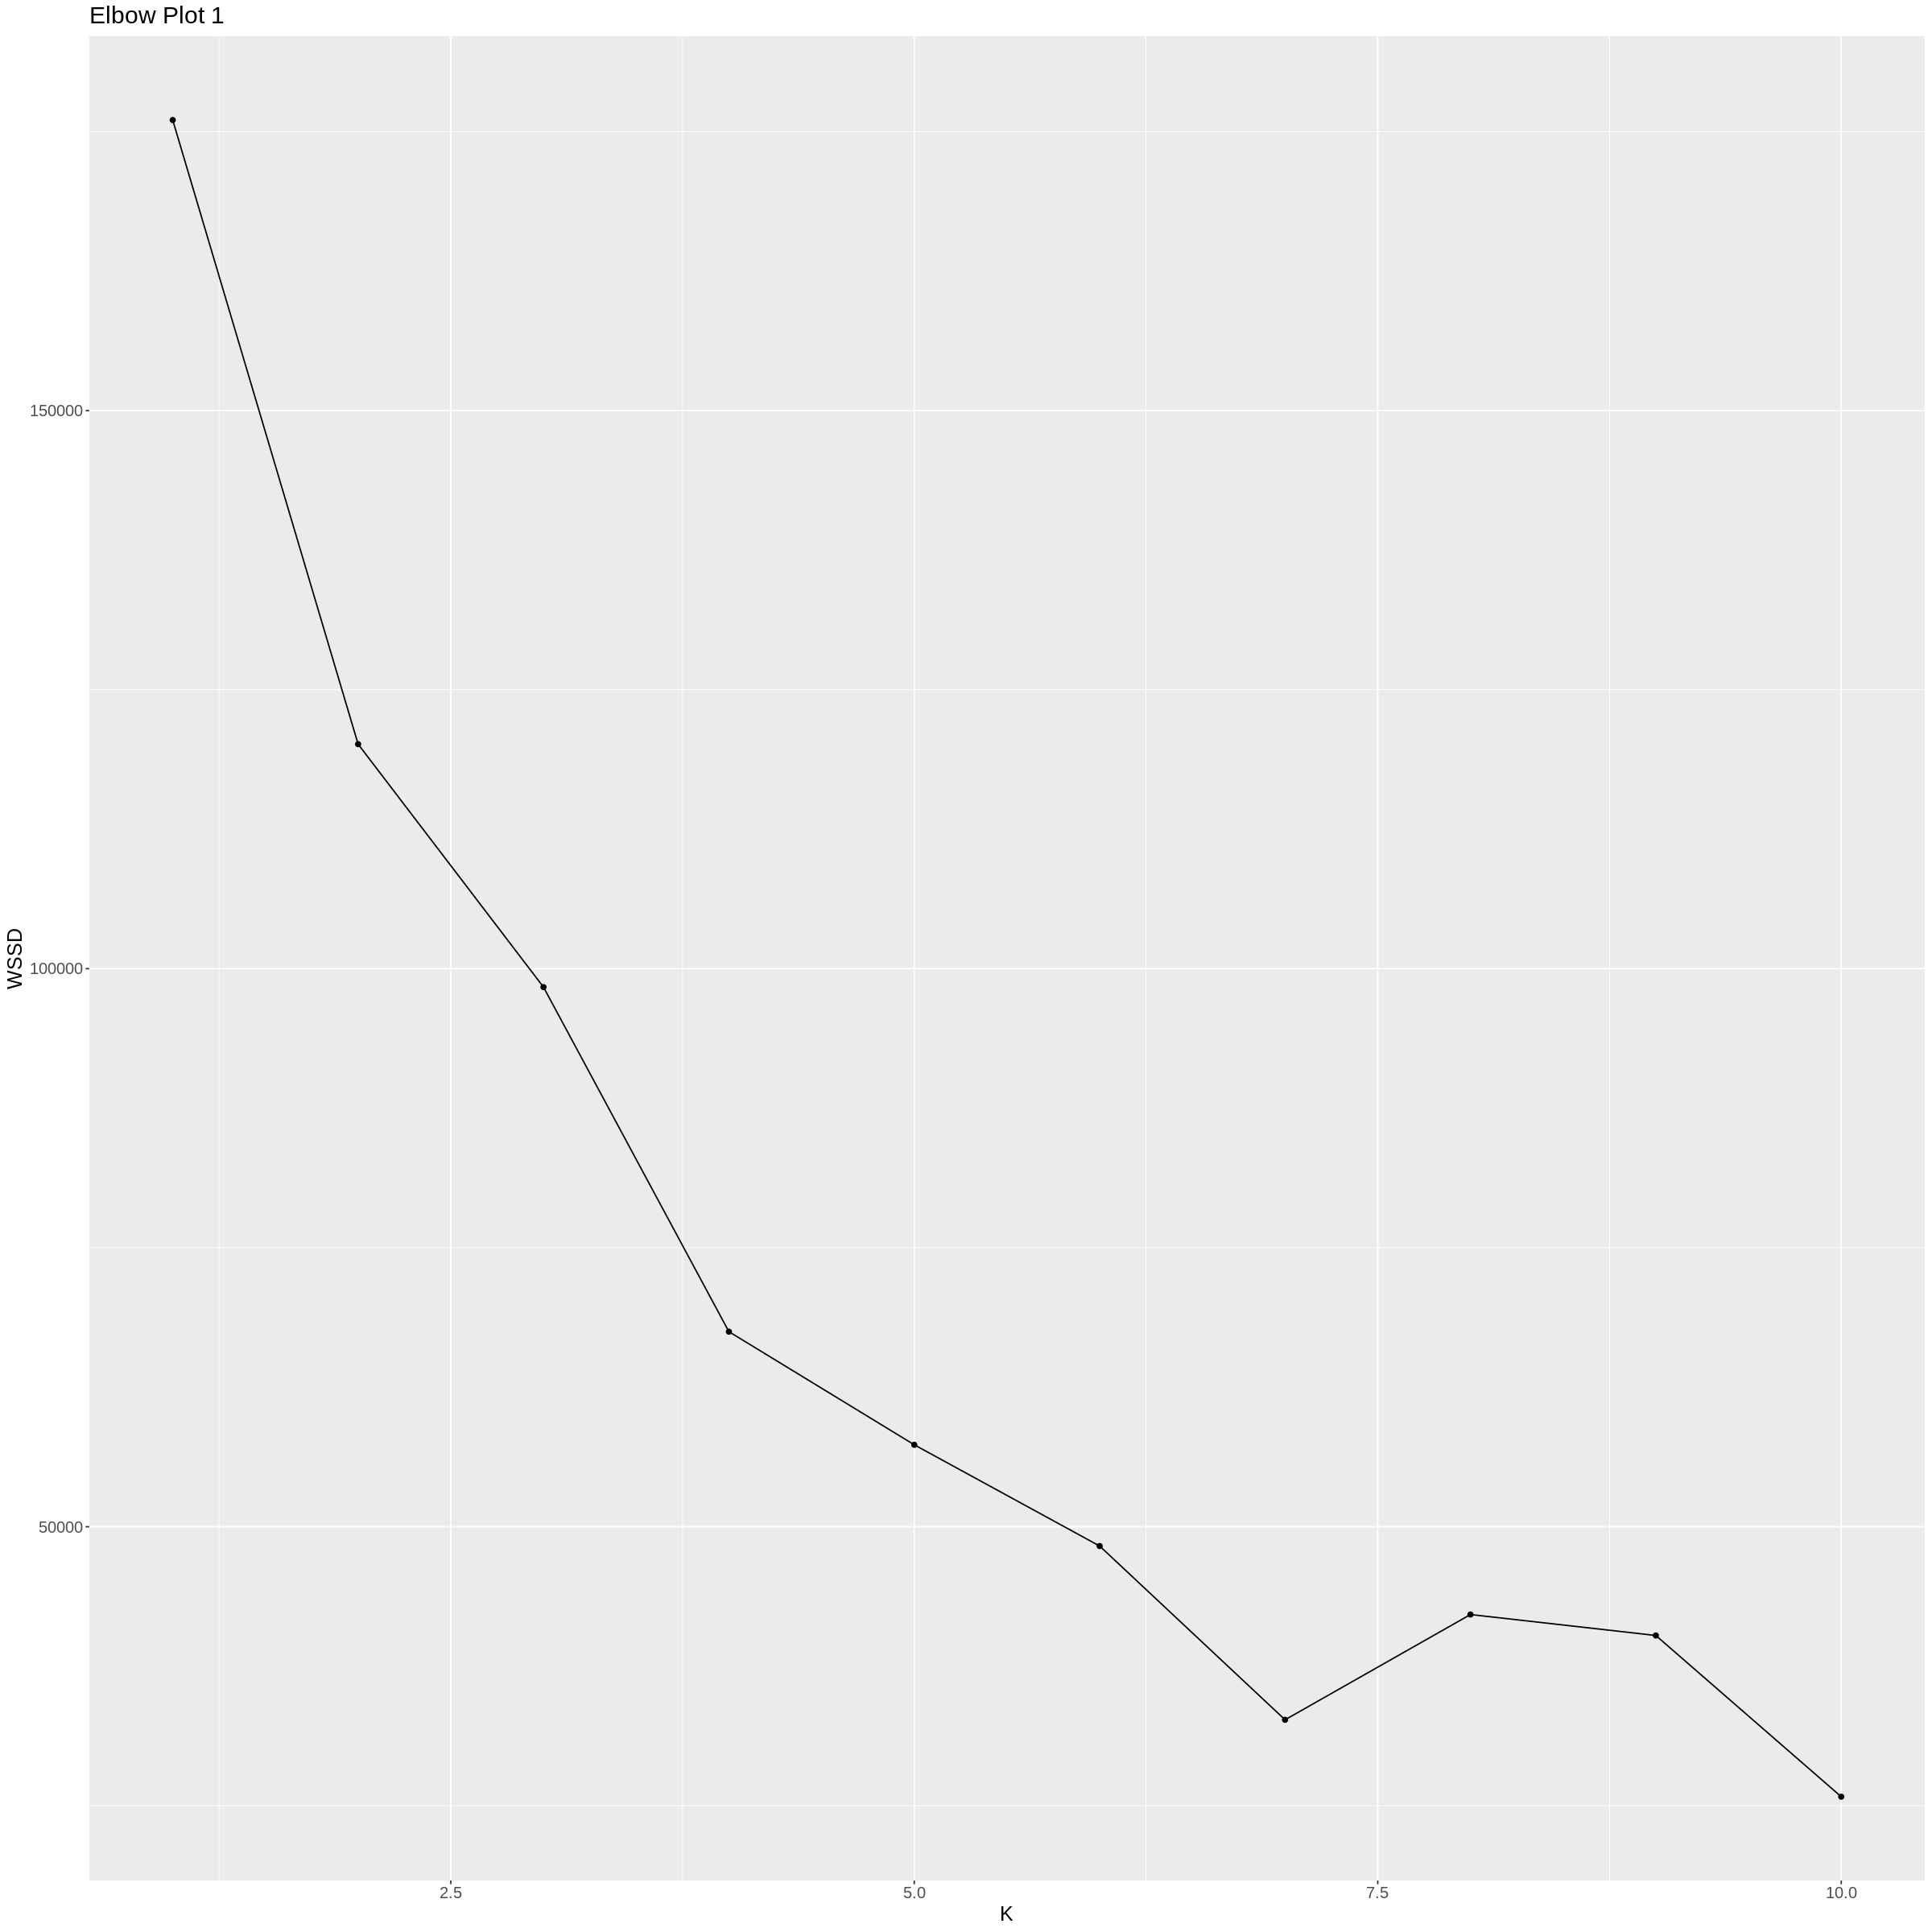

In [80]:
set.seed(9876)
#select for variables we want to cluster by
#then scale them
scaled_property_1 <- property_housing_only |>
    select(CURRENT_LAND_VALUE, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_1, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 1") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

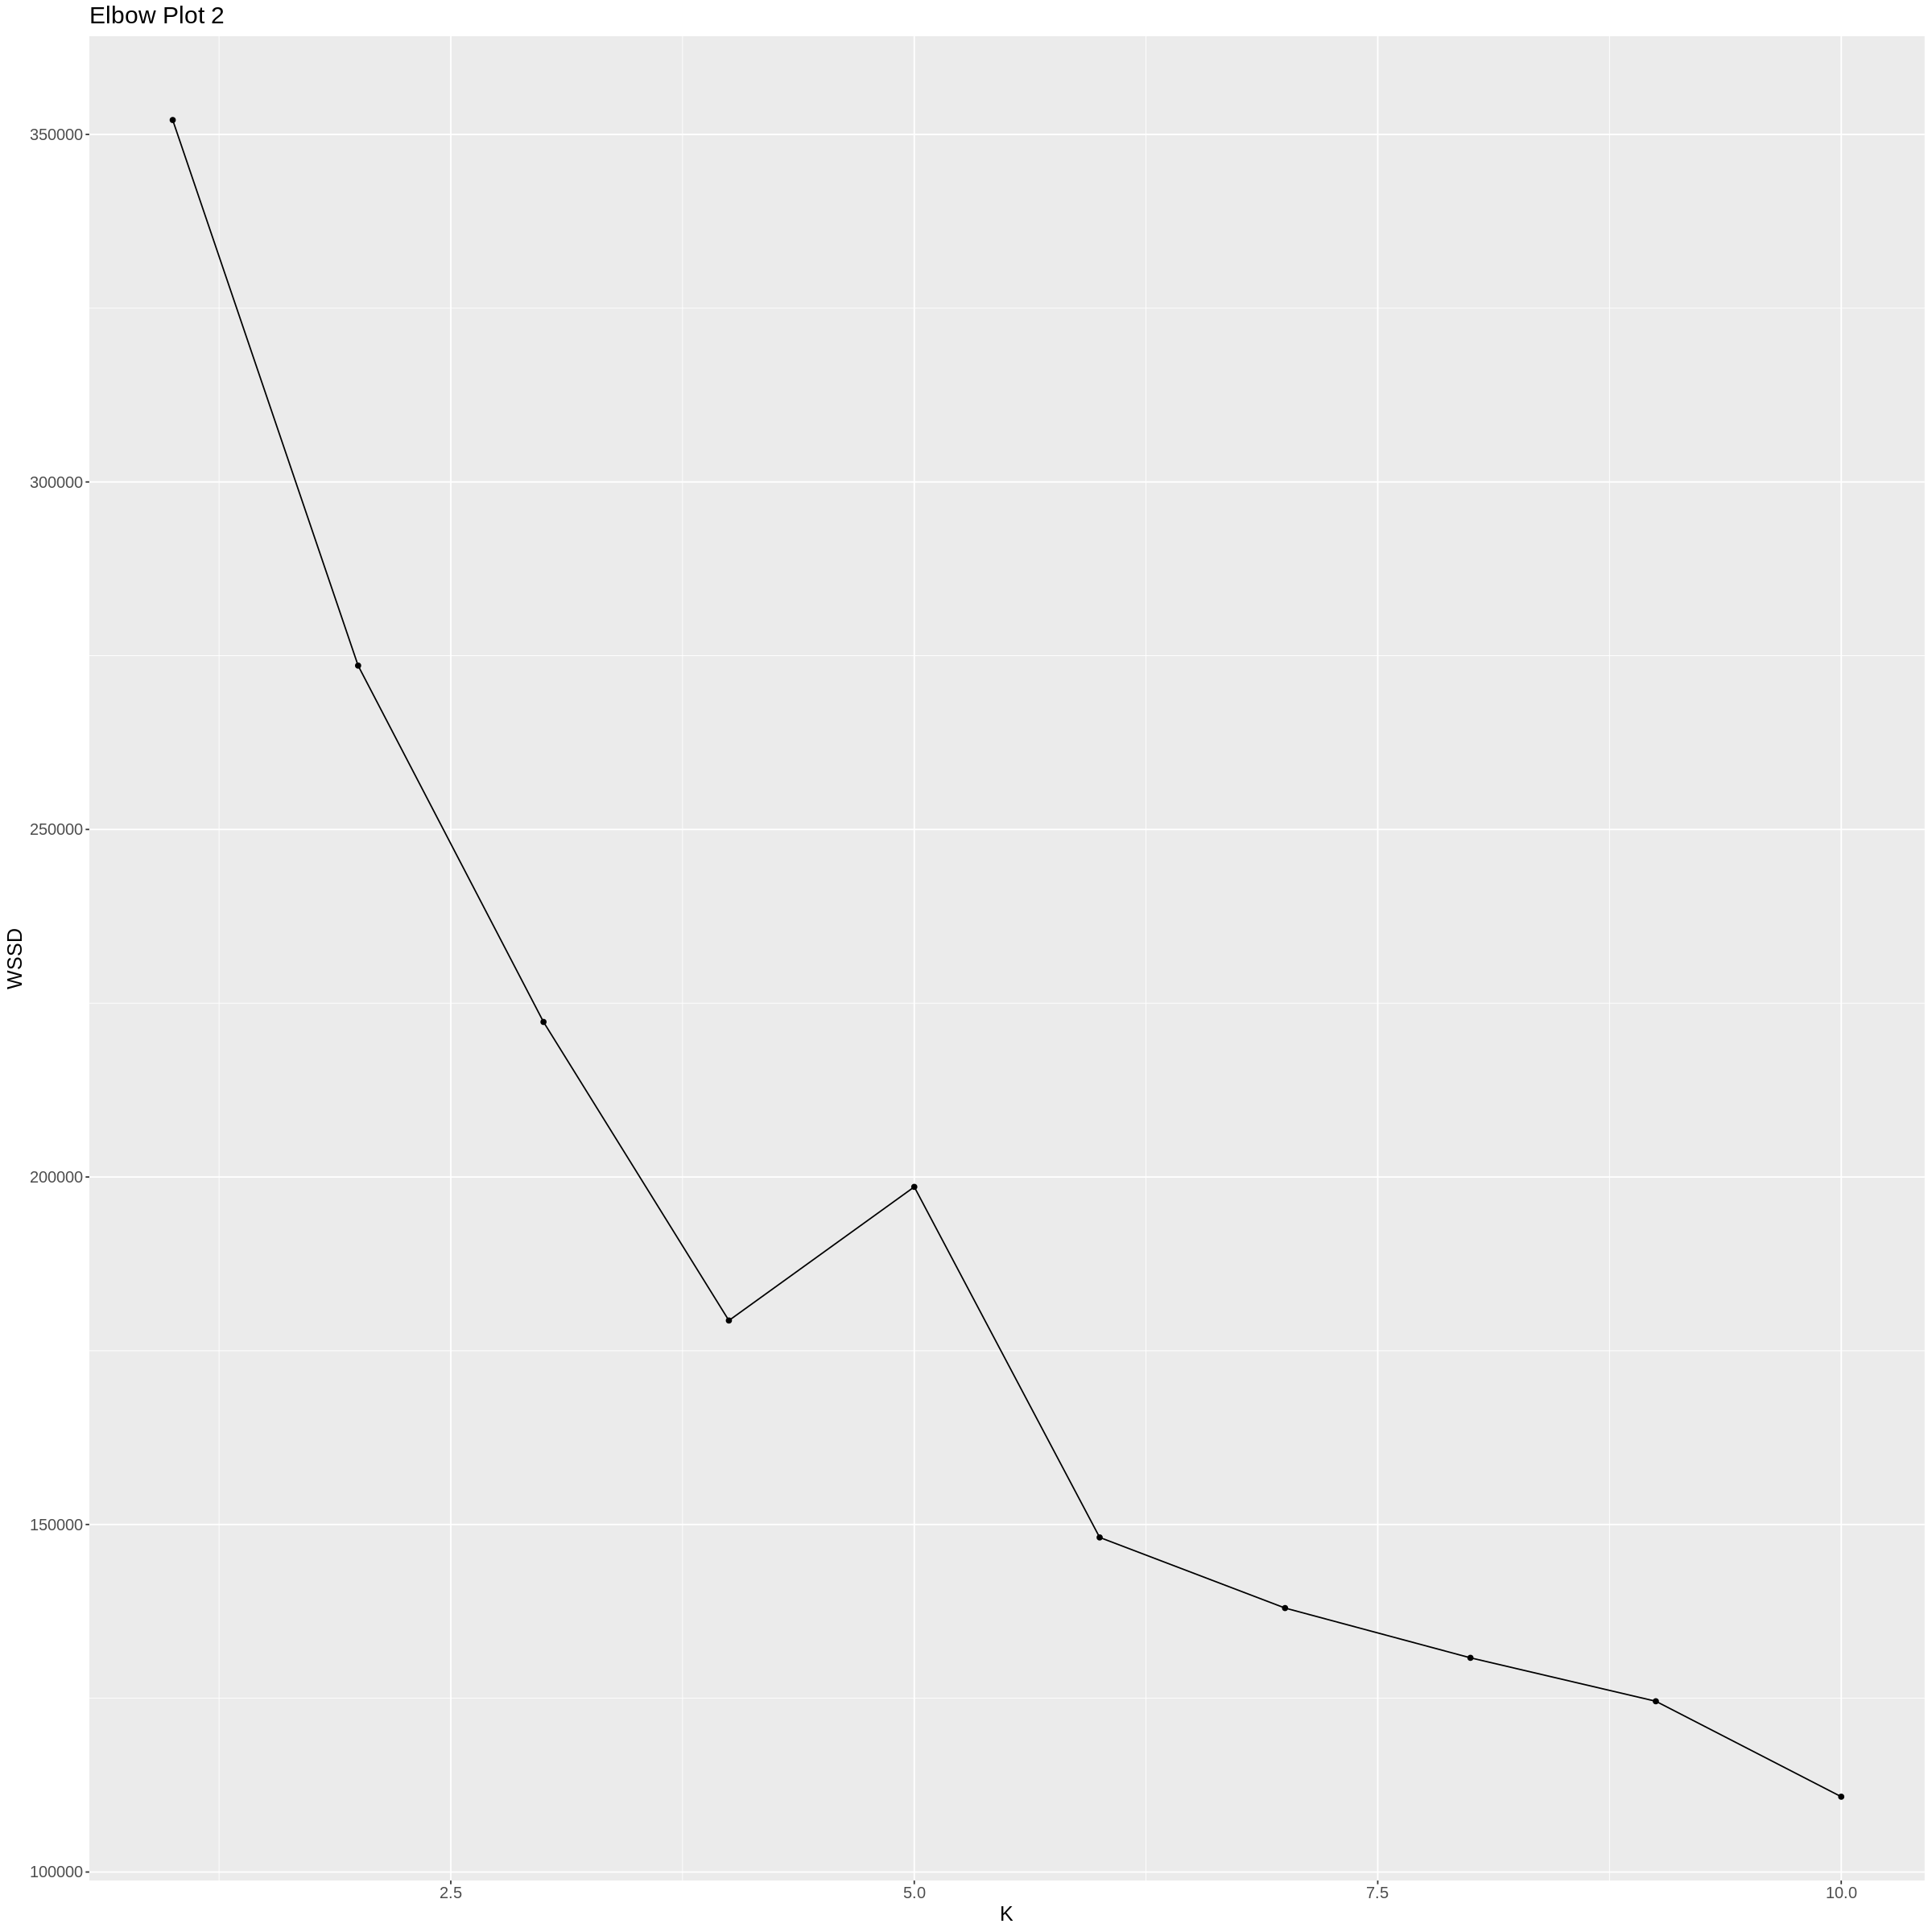

In [81]:
set.seed(9876)
scaled_property_2 <- property_housing_only |>
    select(CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, 
           YEAR_BUILT, BIG_IMPROVEMENT_YEAR, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_2, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 2") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4???

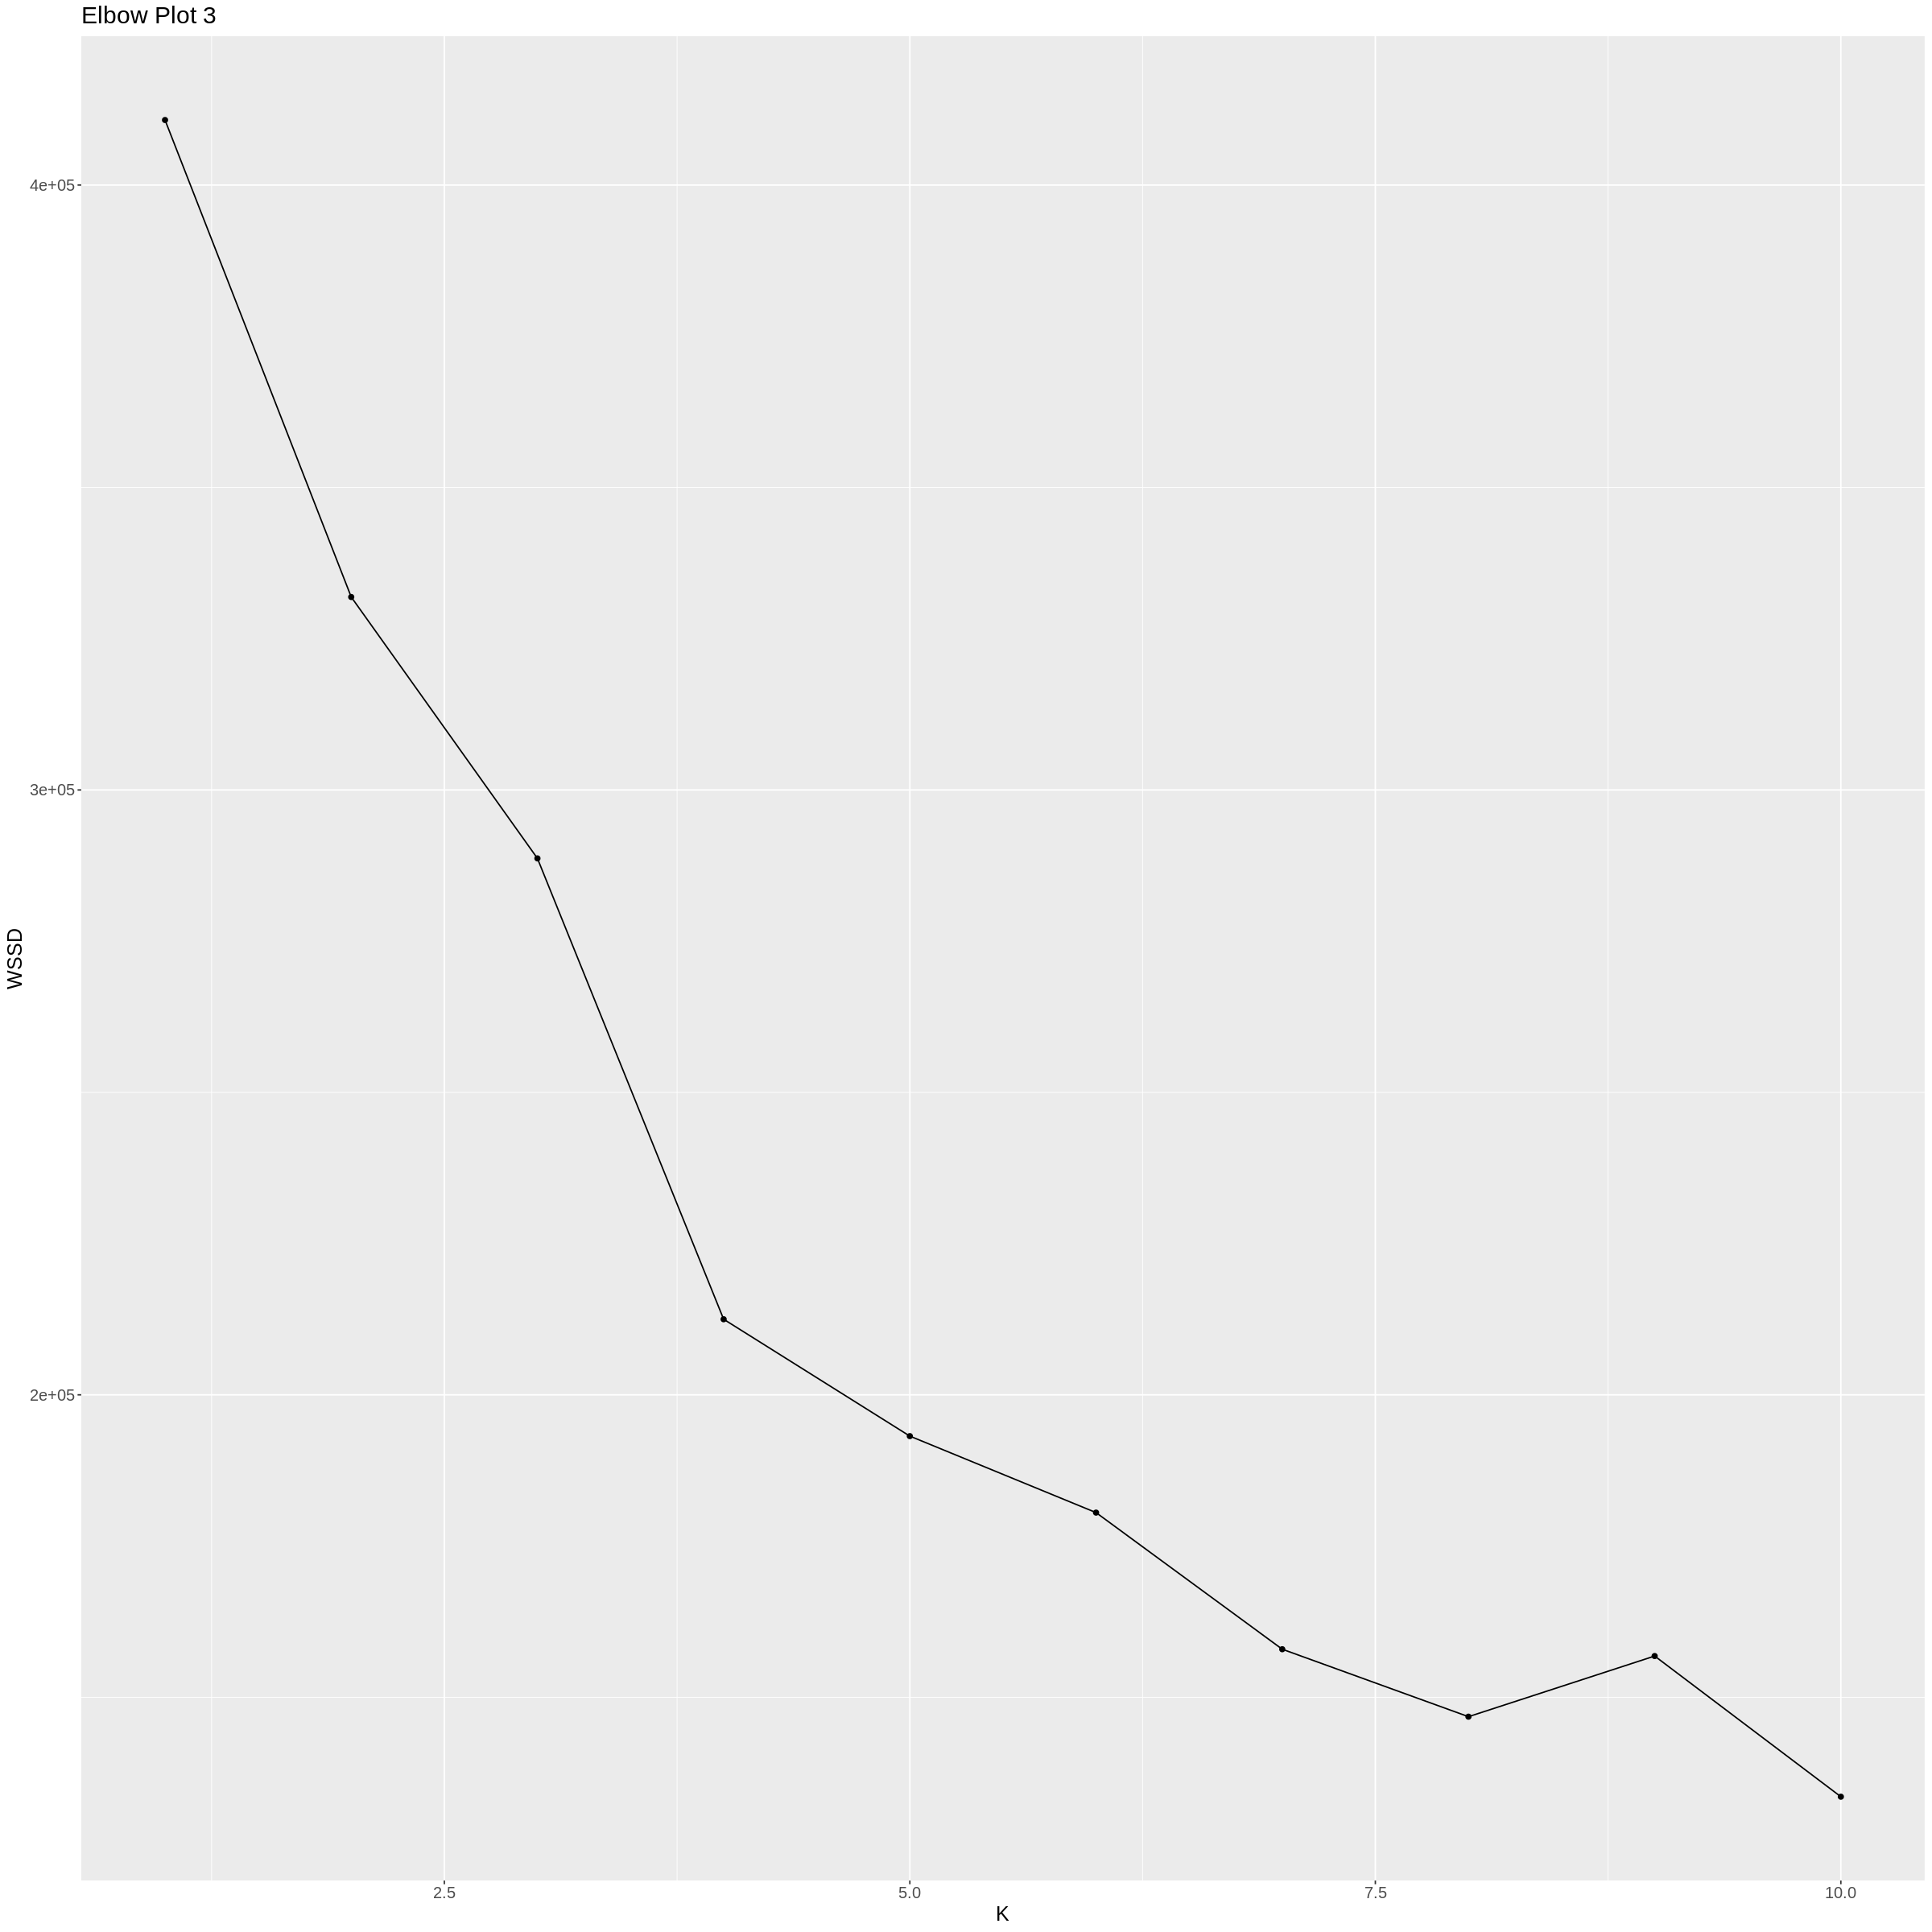

In [82]:
set.seed(9876)
scaled_property_3 <- property_housing_only |>
    select(CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, 
           YEAR_BUILT, BIG_IMPROVEMENT_YEAR, TAX_LEVY, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_3, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 3") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

<h2> </h2>

In [15]:
#BEYOND THIS POINT, WE ARE AGGREGATING APARTMENTS TOGETHER
#
#
#
#
#
#
#
#
#
#
#
#
#AND IT BEGINS

`summarise()` has grouped output by 'lat'. You can override using the `.groups`
argument.


lat      long      AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE
1 49.20285 -123.0247 33723000                      62400                     
2 49.20317 -123.0267 10053201                       4000                     
3 49.20330 -123.0275  9875399                       4000                     
4 49.20338 -123.1291     2700                       8300                     
5 49.20404 -123.1358  1791000                     327200                     
6 49.20429 -123.0247     2700                       8300                     
  MEAN_YEAR_BUILT MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY SAME_ADDRESS_ENTRIES
1 2003            2003                      215163.000    1                   
2 2005            2005                       56736.200    1                   
3 2005            2005                       55489.800    1                   
4 1998            1998                         489.620    1                   
5 1975            1975                        1178.018    5                   
6 1998            1998                         489.620    1

[1] "Same-address Property Value Entries: 27184  /  58988  total"


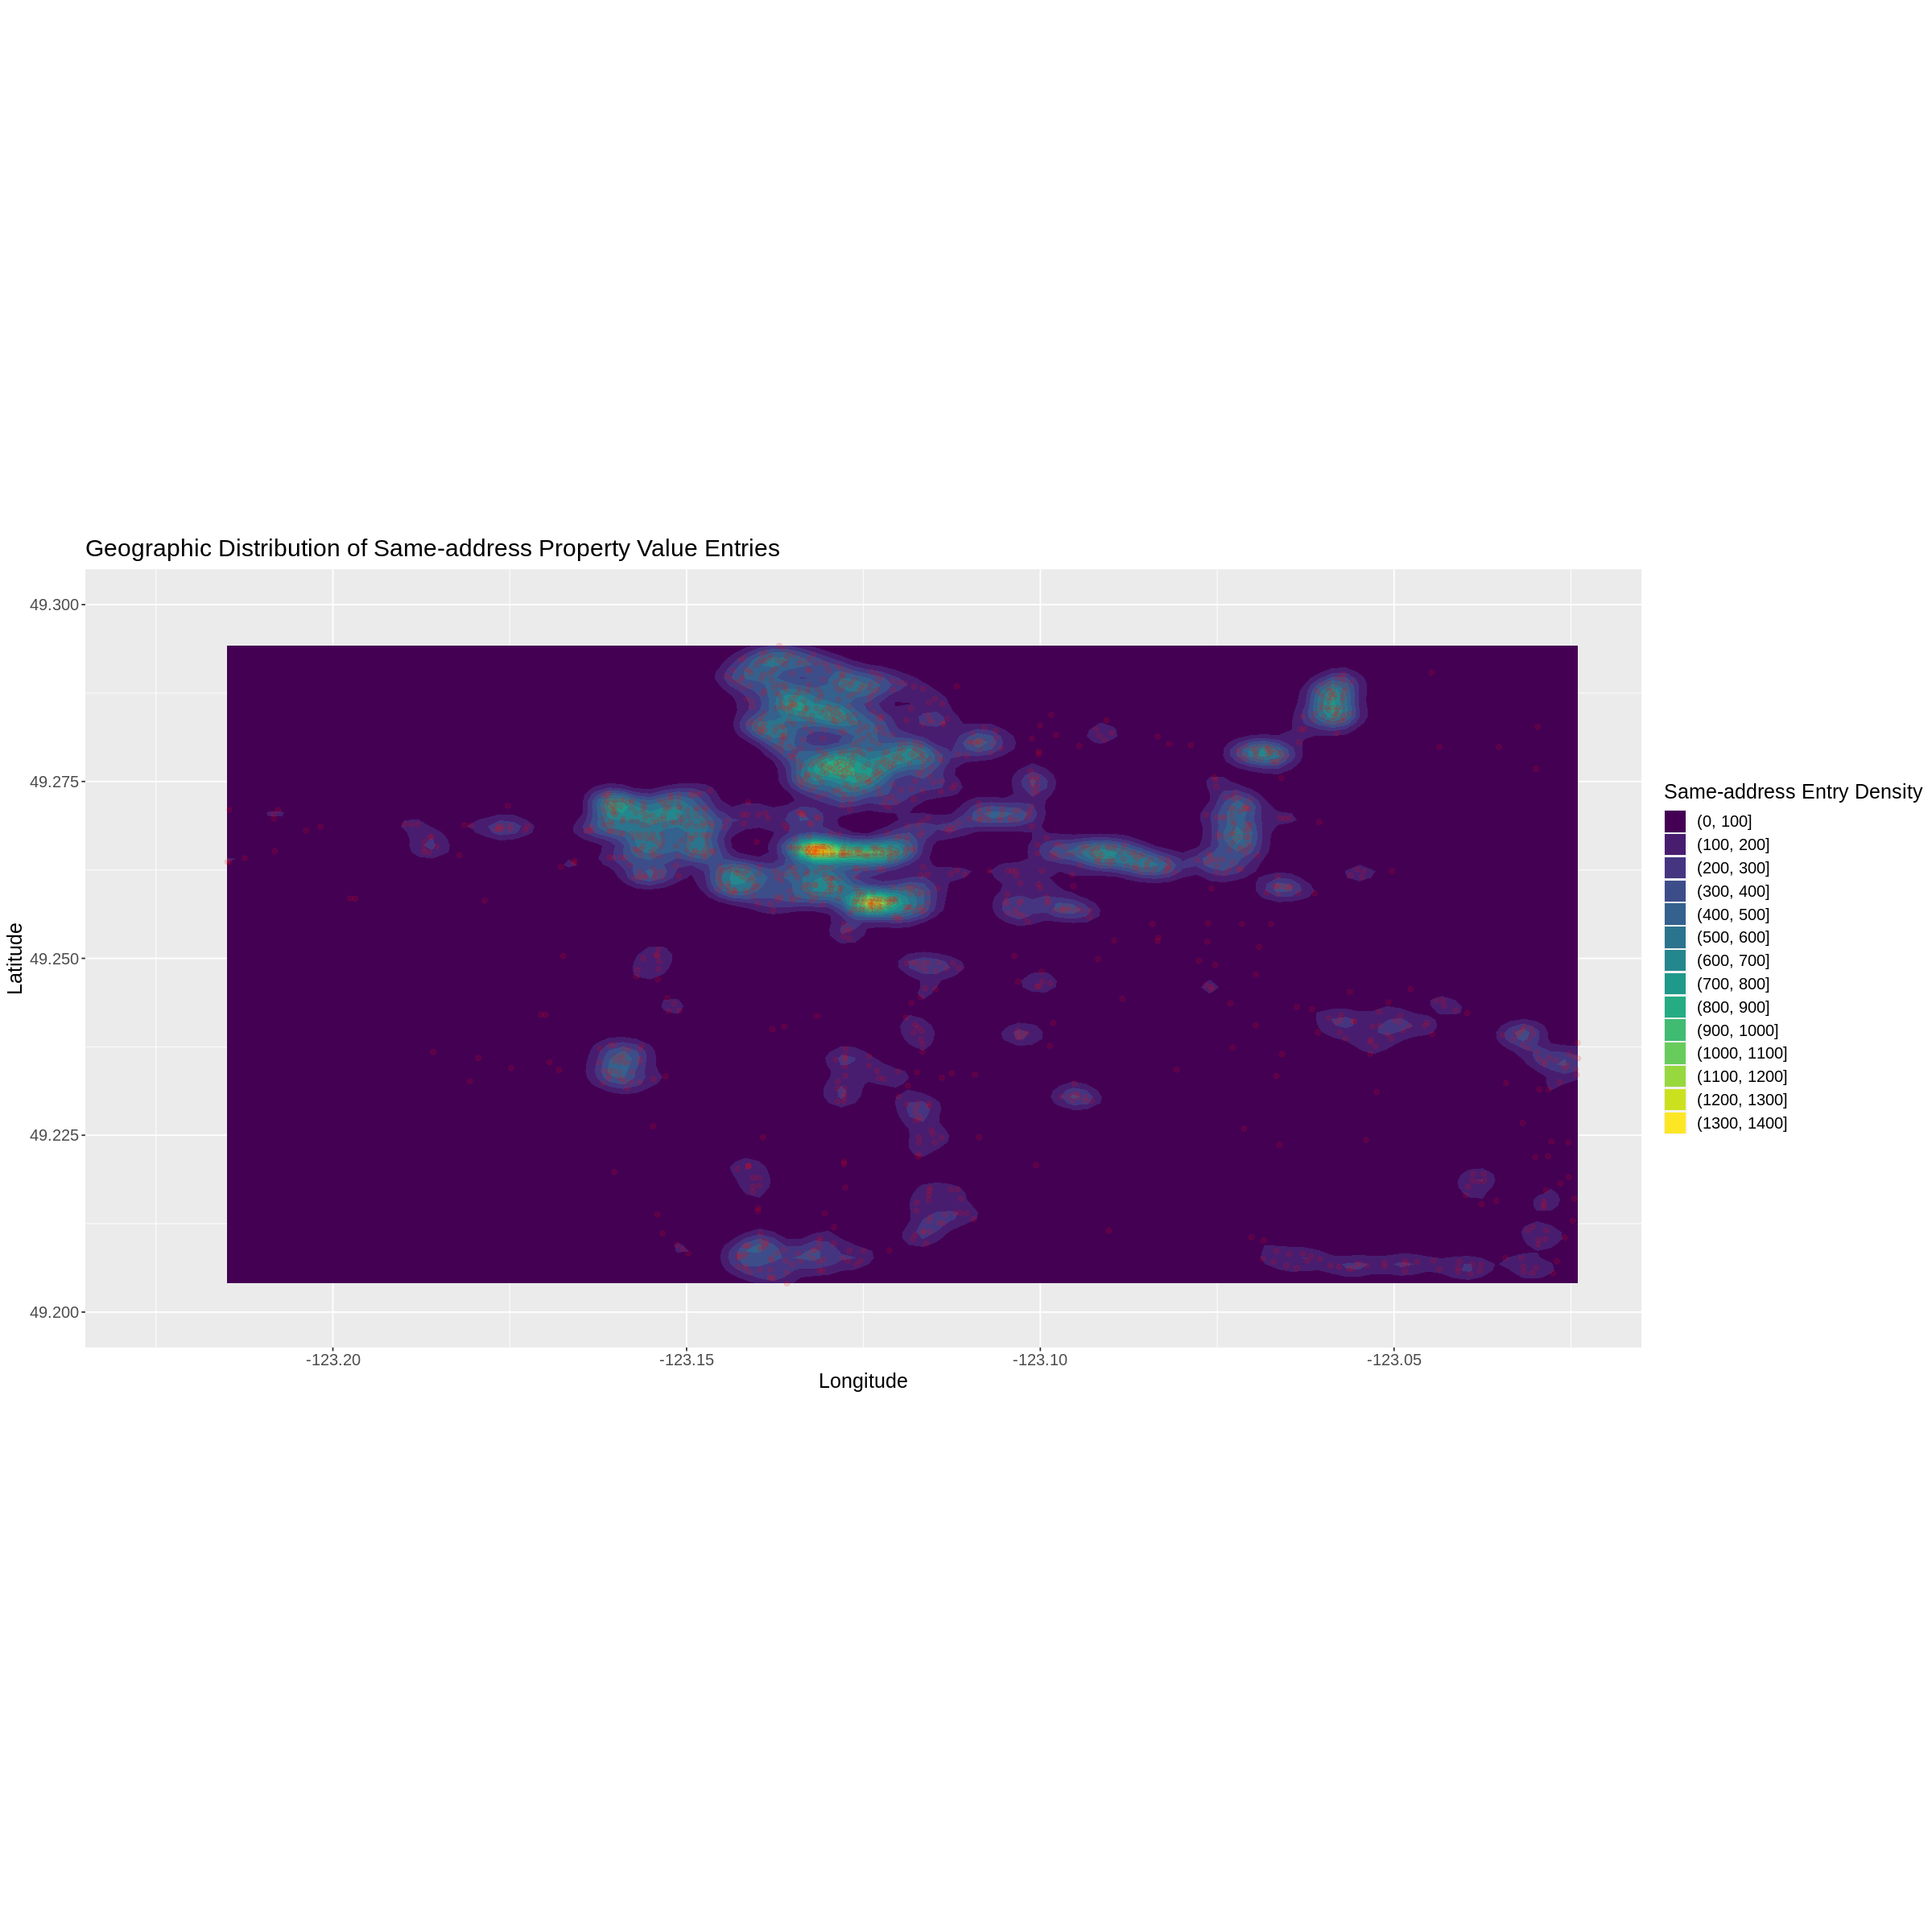

In [6]:
## Address Aggregation
# Find count of same-address property value entries by location

housing_aggregated <- property_housing_only |>
                        group_by(lat, long) |>
                        arrange(long) |>
                        summarize(AGGREGATE_CURRENT_LAND_VALUE = sum(CURRENT_LAND_VALUE),
                                  AGGREGATE_IMPROVEMENT_VALUE = sum(CURRENT_IMPROVEMENT_VALUE),
                                  MEAN_YEAR_BUILT = mean(YEAR_BUILT),
                                  MEAN_BIG_IMPROVEMENT_YEAR = mean(BIG_IMPROVEMENT_YEAR),
                                  MEAN_TAX_LEVY = mean(TAX_LEVY),
                                  SAME_ADDRESS_ENTRIES = n()) |>
                        as_tibble() #need it to be a tibble (originally a grouped df)
head(housing_aggregated)

print(paste("Same-address Property Value Entries:", nrow(housing_aggregated), " / ", nrow(property_housing_only), " total"))

# Plot Geographic distribution of Same-Address Property Tax Report Entries
options(repr.plot.width = 20, repr.plot.height =20)
property_plot <- housing_aggregated |>
                filter(SAME_ADDRESS_ENTRIES > 1) |>
                ggplot(aes(x=long,y=lat, z= SAME_ADDRESS_ENTRIES)) +
                geom_density_2d_filled(adjust = 1/4) +
                geom_point(alpha = 0.125, color = "red") +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     fill = "Same-address Entry Density", 
                     title = "Geographic Distribution of Same-address Property Value Entries") +
                theme(text = element_text(size = 15))
property_plot

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


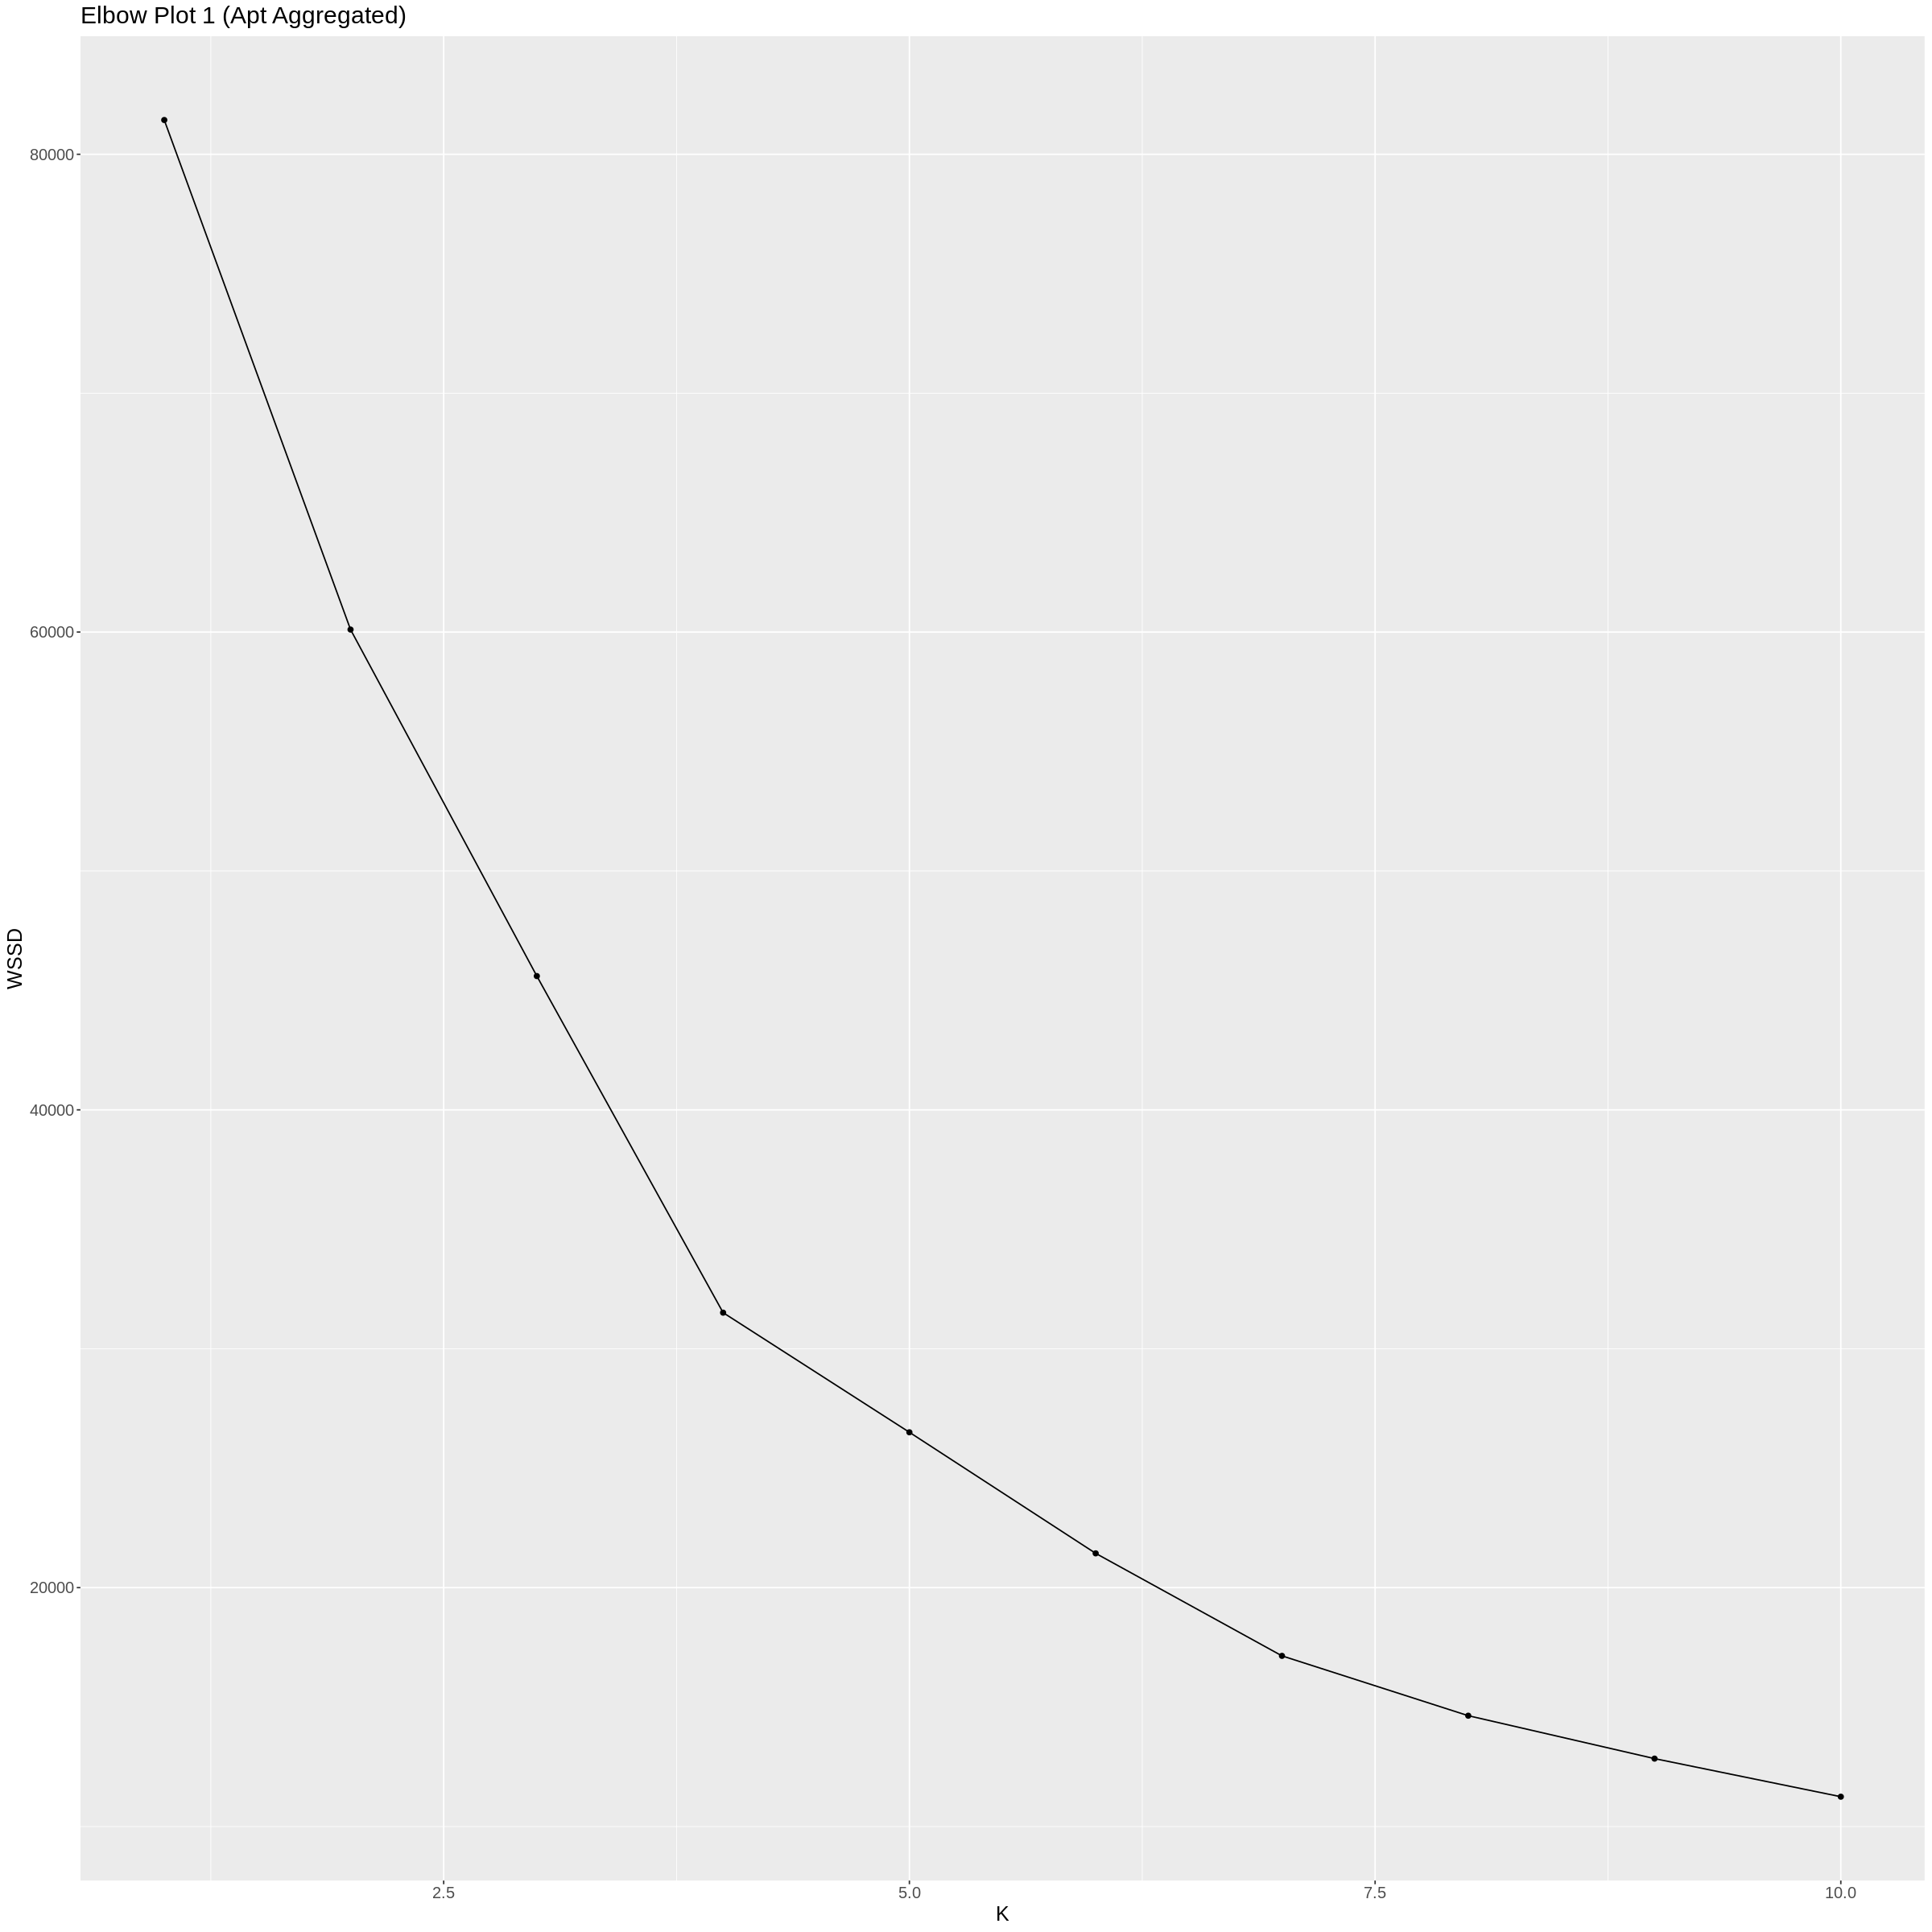

In [83]:
set.seed(9876)
#select for variables we want to cluster by
#then scale them
scaled_property_agg_1 <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_1, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 1 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


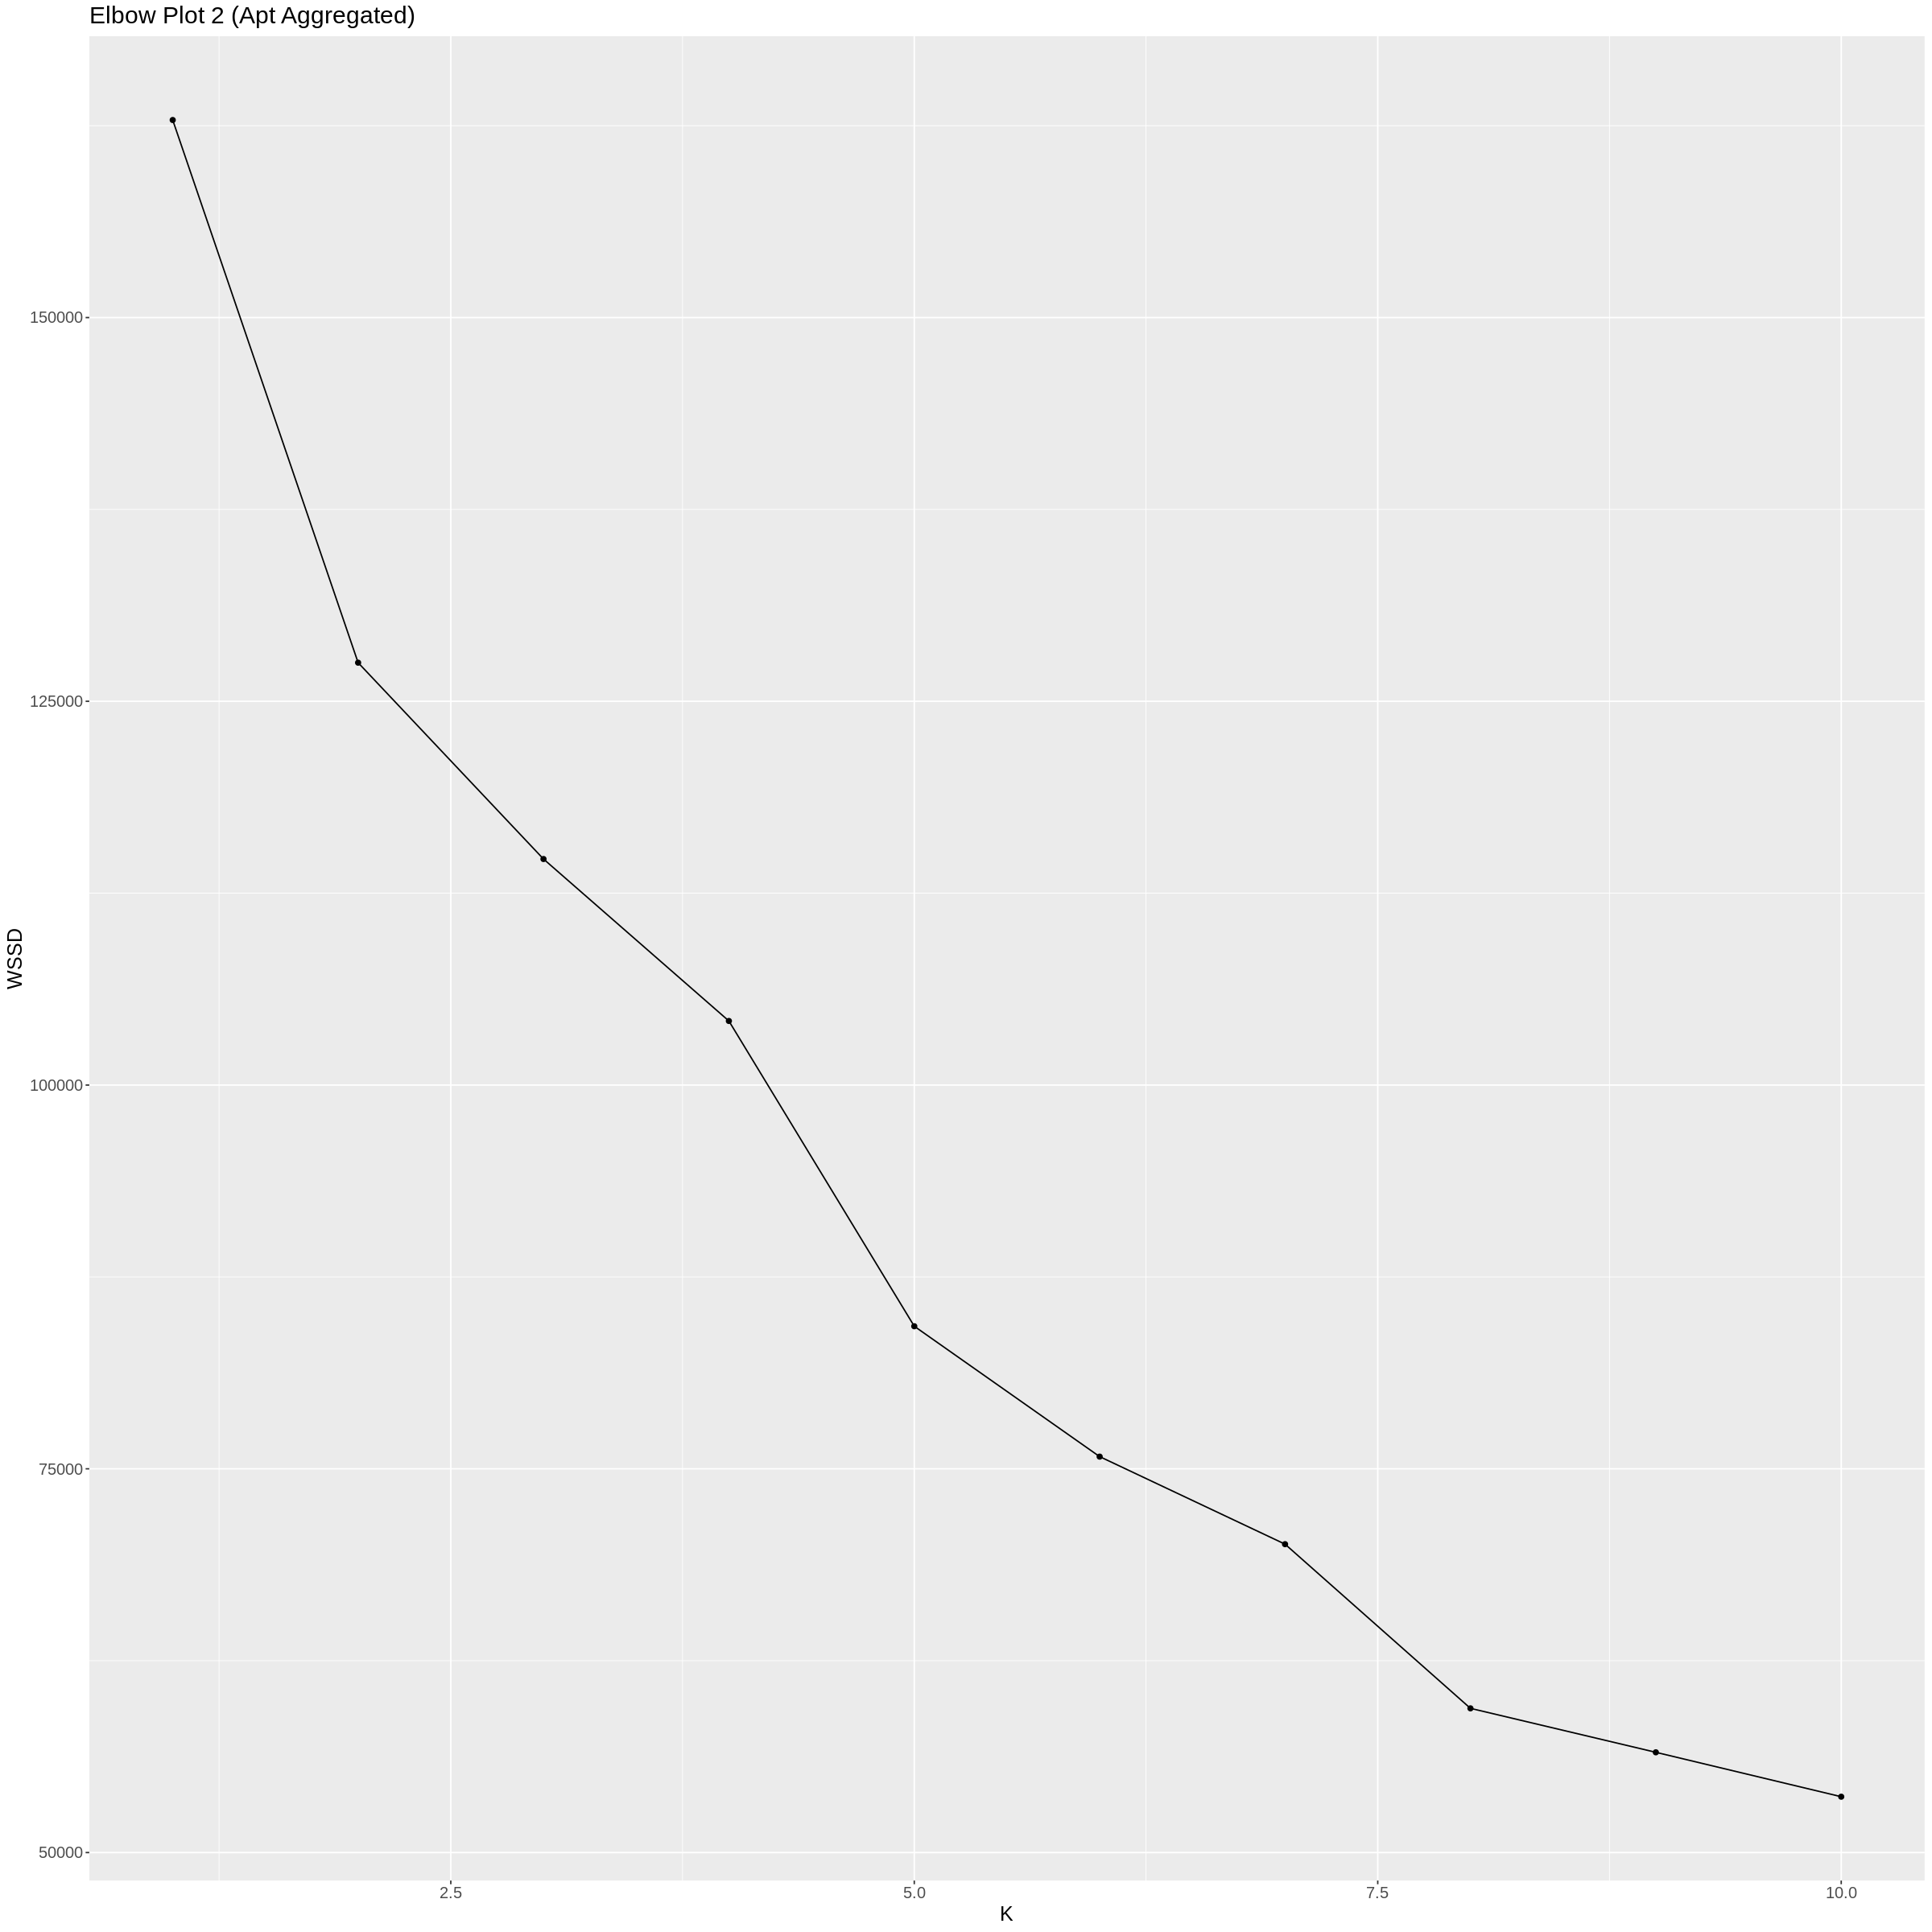

In [119]:
set.seed(9876)
scaled_property_agg_2 <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, AGGREGATE_IMPROVEMENT_VALUE,
           MEAN_YEAR_BUILT, MEAN_BIG_IMPROVEMENT_YEAR, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_2, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 2 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4???

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


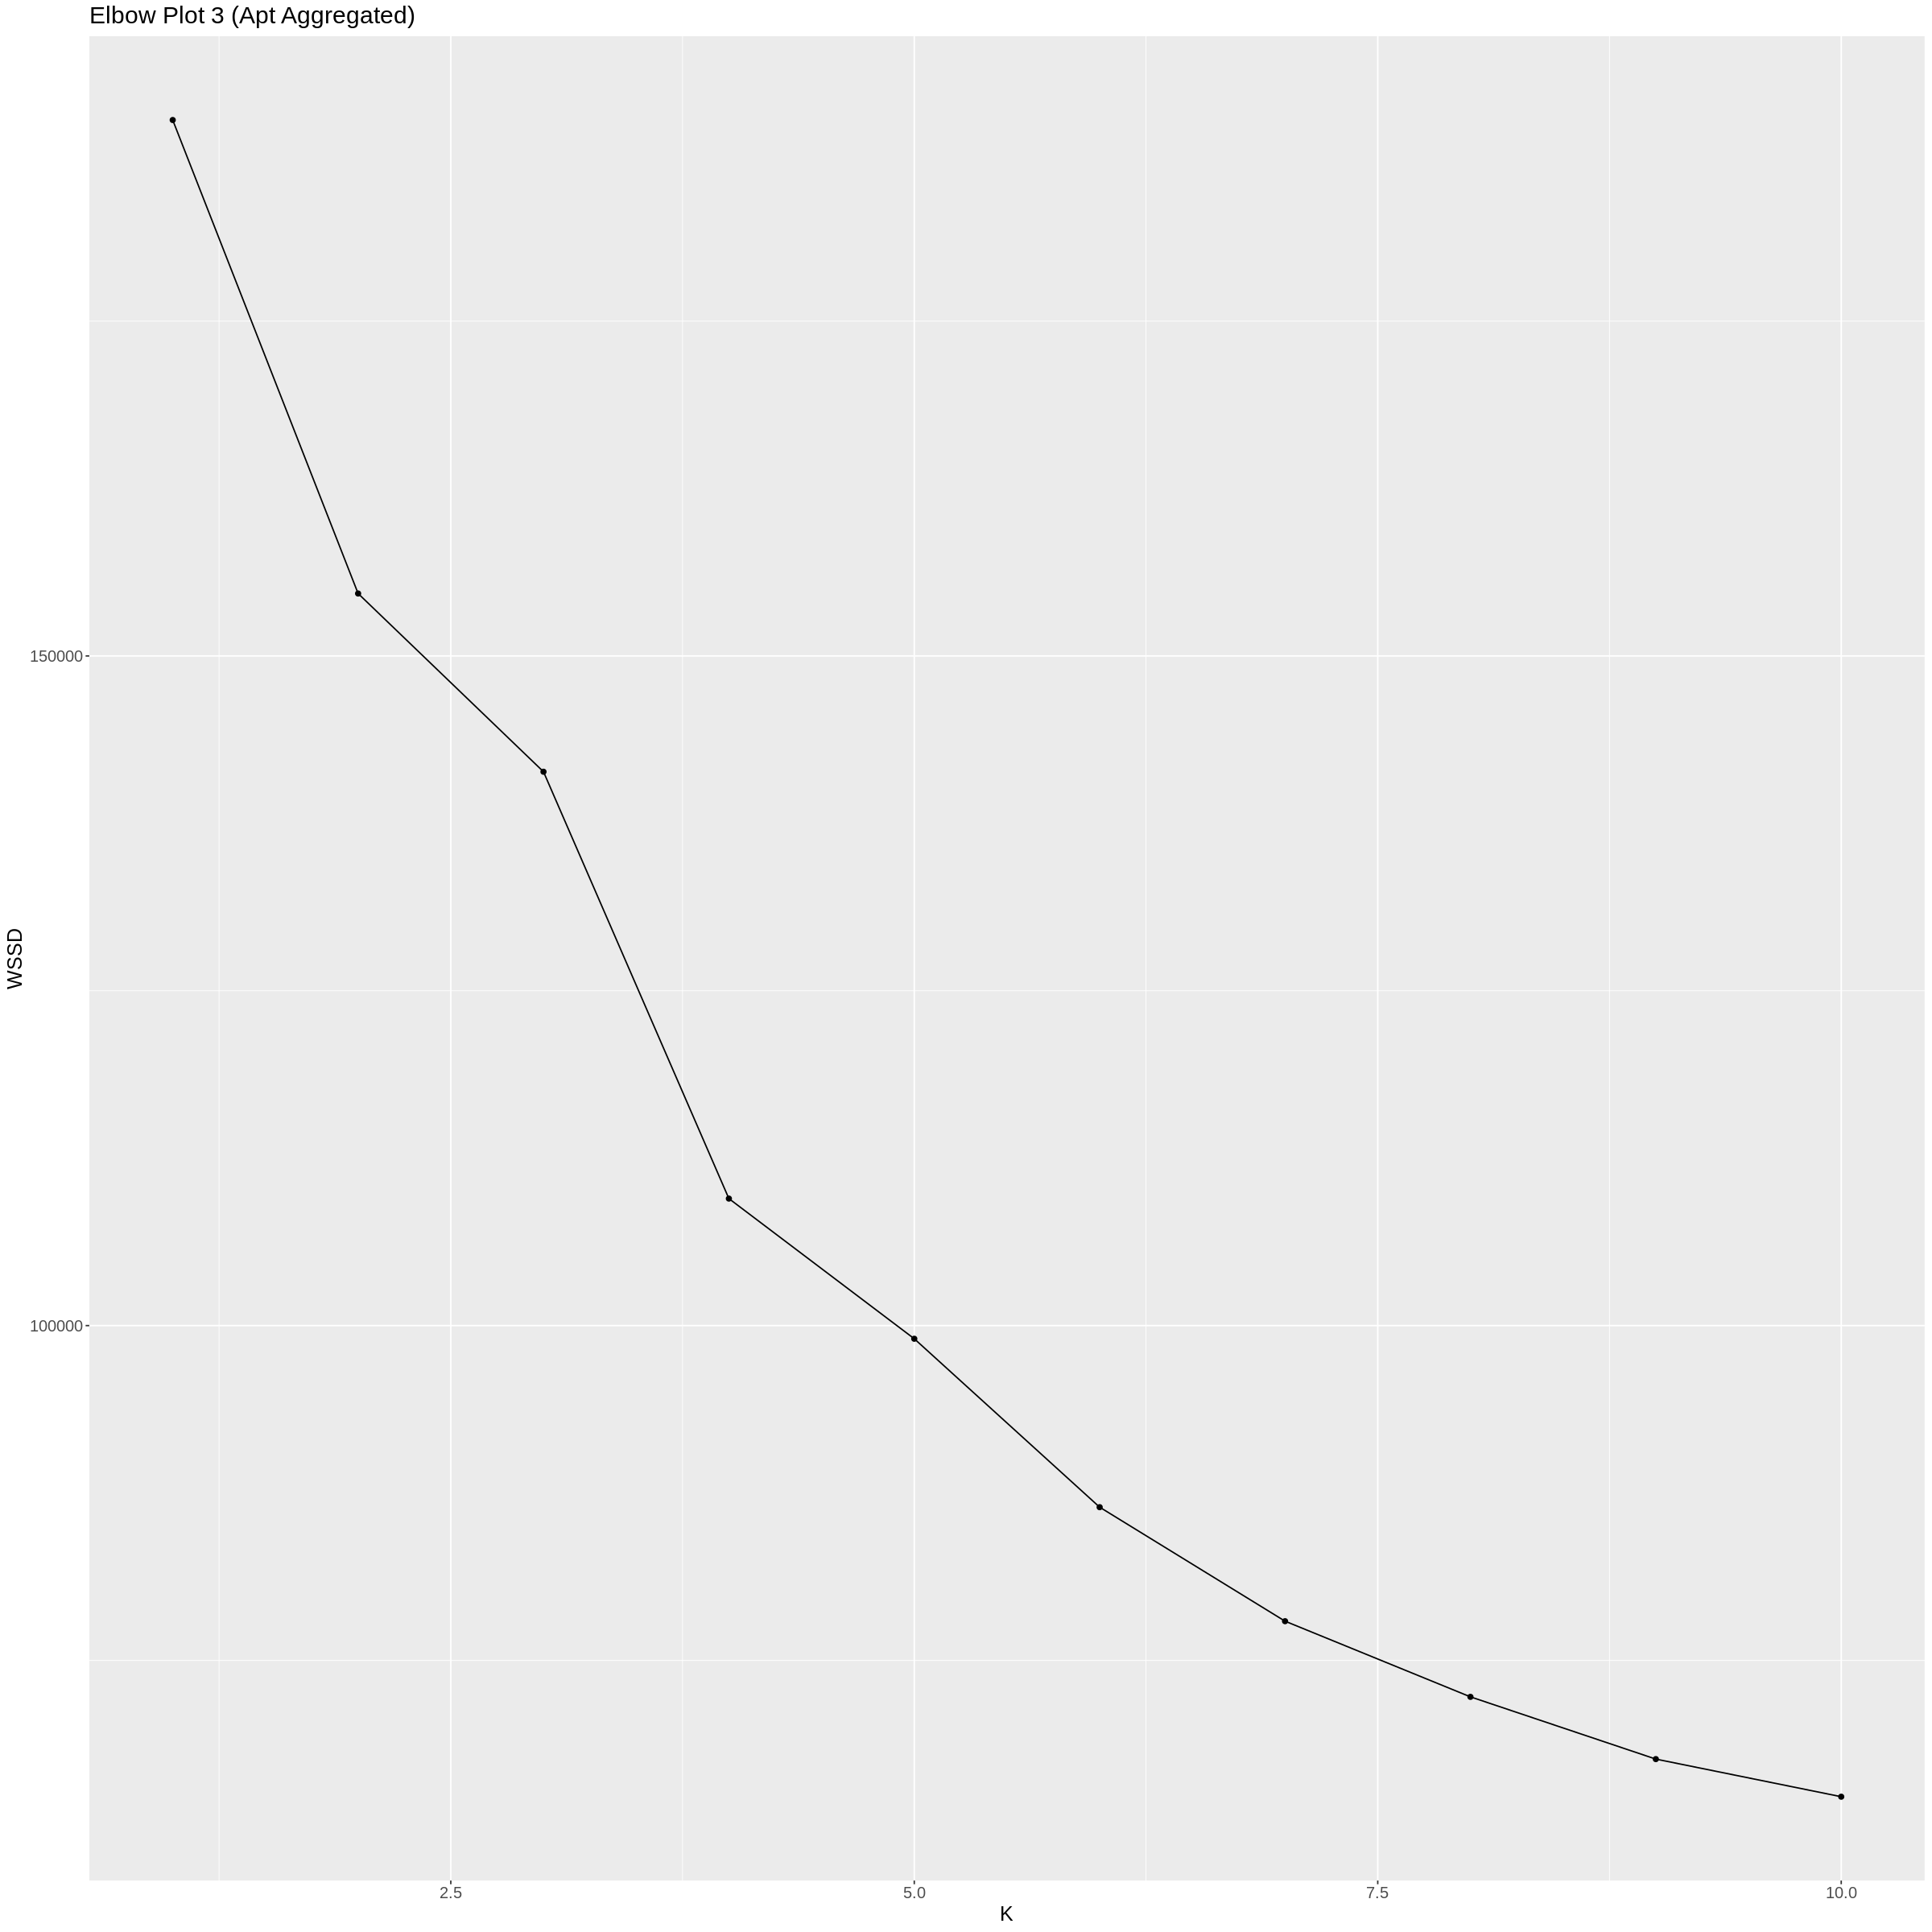

In [39]:
set.seed(9876)
scaled_property_agg_3 <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, AGGREGATE_IMPROVEMENT_VALUE,
           MEAN_YEAR_BUILT, MEAN_BIG_IMPROVEMENT_YEAR, MEAN_TAX_LEVY, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_3, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 3 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4

AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE MEAN_YEAR_BUILT
1 -0.28258224                  -0.14447684                  0.86637337    
2 -0.03963238                  -0.08136100                  0.14110545    
3  0.09563793                  -0.01838554                 -0.07962826    
4 -0.28258224                  -0.14447684                  0.86637337    
5  0.54690537                   4.95119050                  1.62317468    
6 -0.09575791                  -0.04584552                  0.48797272    
  MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY lat       long       .cluster
1  0.7110076                -0.16343324   -2.029025 -0.4928004 2       
2 -0.3937640                -0.15754334   -1.996884 -0.6221204 2       
3 -0.7299988                 0.02455912   -1.991206 -0.6278243 1       
4  0.7110076                -0.16343324   -1.985125  1.5019575 2       
5  1.8638128                 1.47281958   -1.978267  1.3259091 2       
6  0.1346051                -0.15537106   -1.964202 -0.6576758 2

Warning message:
“Removed 723 rows containing non-finite values (stat_density).”


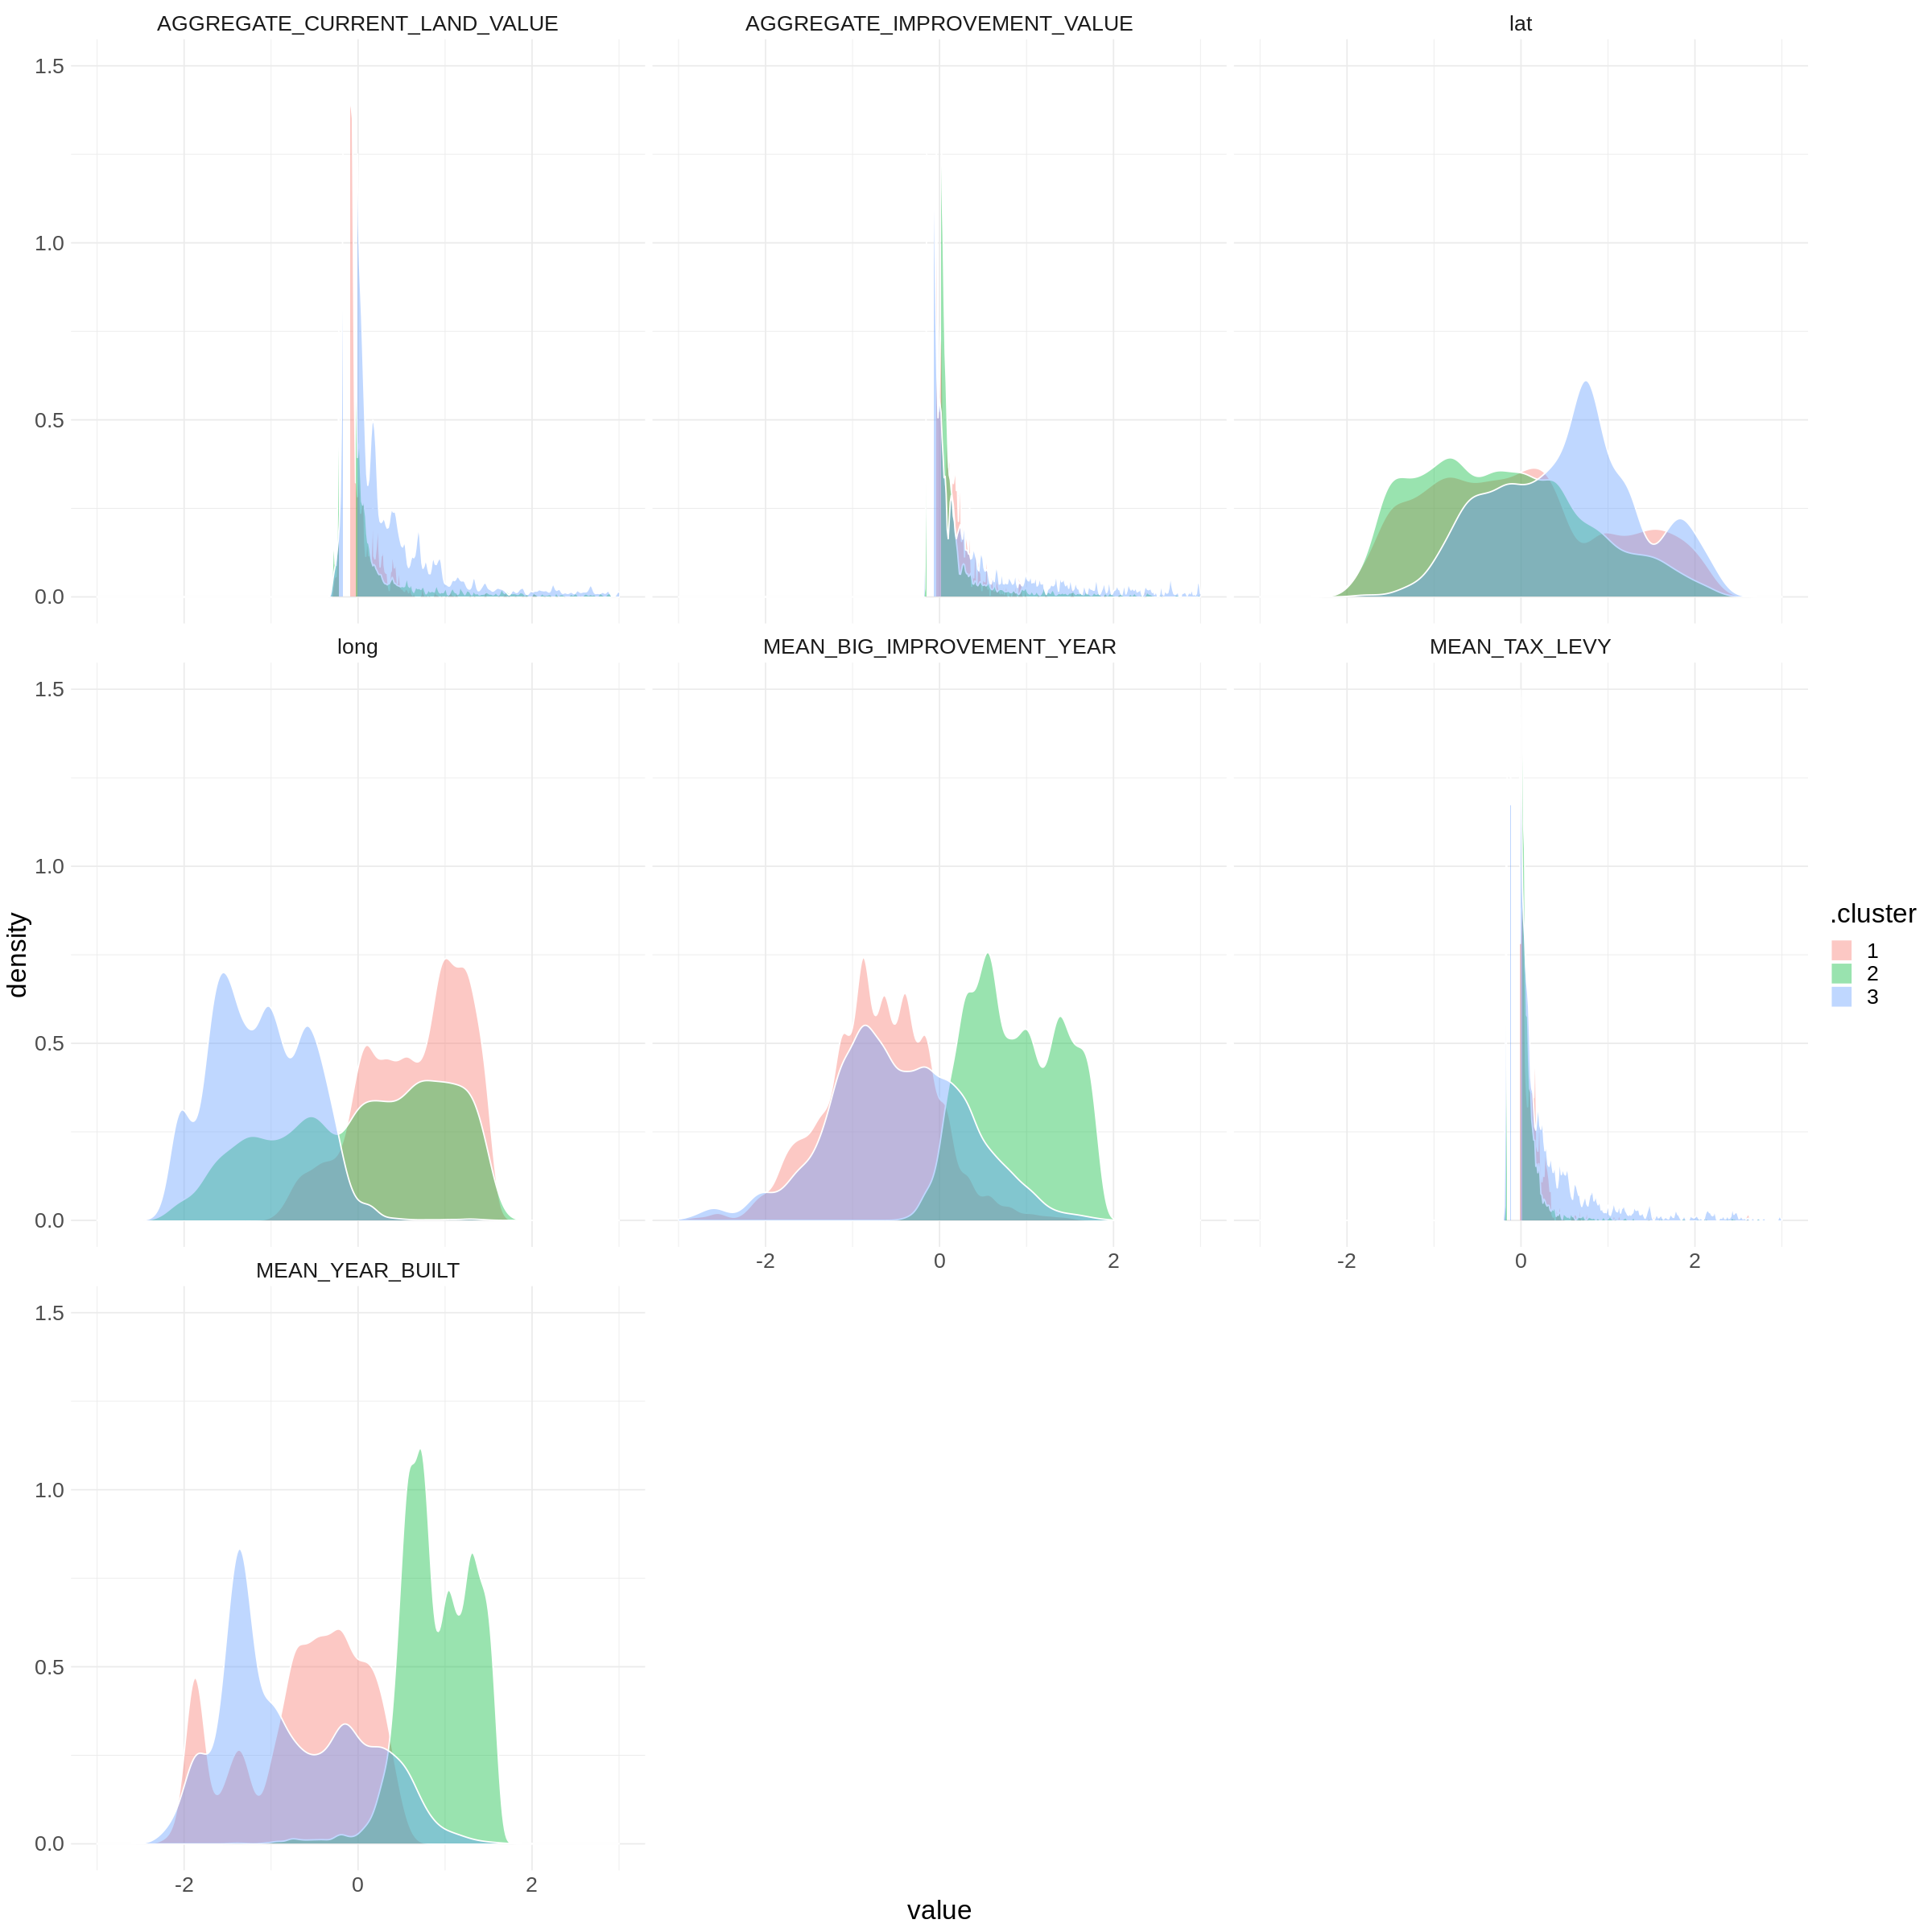

In [40]:
set.seed(9876)
agg_property_clusters <- kmeans(scaled_property_agg_3, centers = 3) |>
    augment(scaled_property_agg_3)
head(agg_property_clusters)

variable_dist <- agg_property_clusters |>
    pivot_longer(cols = -.cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category)) +
        theme_minimal() +
        theme(text = element_text(size = 20)) +
        xlim(-3, 3) +
        ylim(0, 1.5)
variable_dist

Based on the above density plots, year built and big improvement year are highly correlated, so of the two we will only use year built.

Likewise, current land value and current improvement value are highly correlated, so of the two we will only use current land value. Although similarly shaped, mean tax levy has the cluster's densities distributied differenly, so it will also be included.

Latitude and longitude will both still be included, since the plots show that they drive the clusters to differen degrees.

Variables to keep: year built, current land value, tax levy, latitude, longitude

DESCRIPTION MAY CHANGE

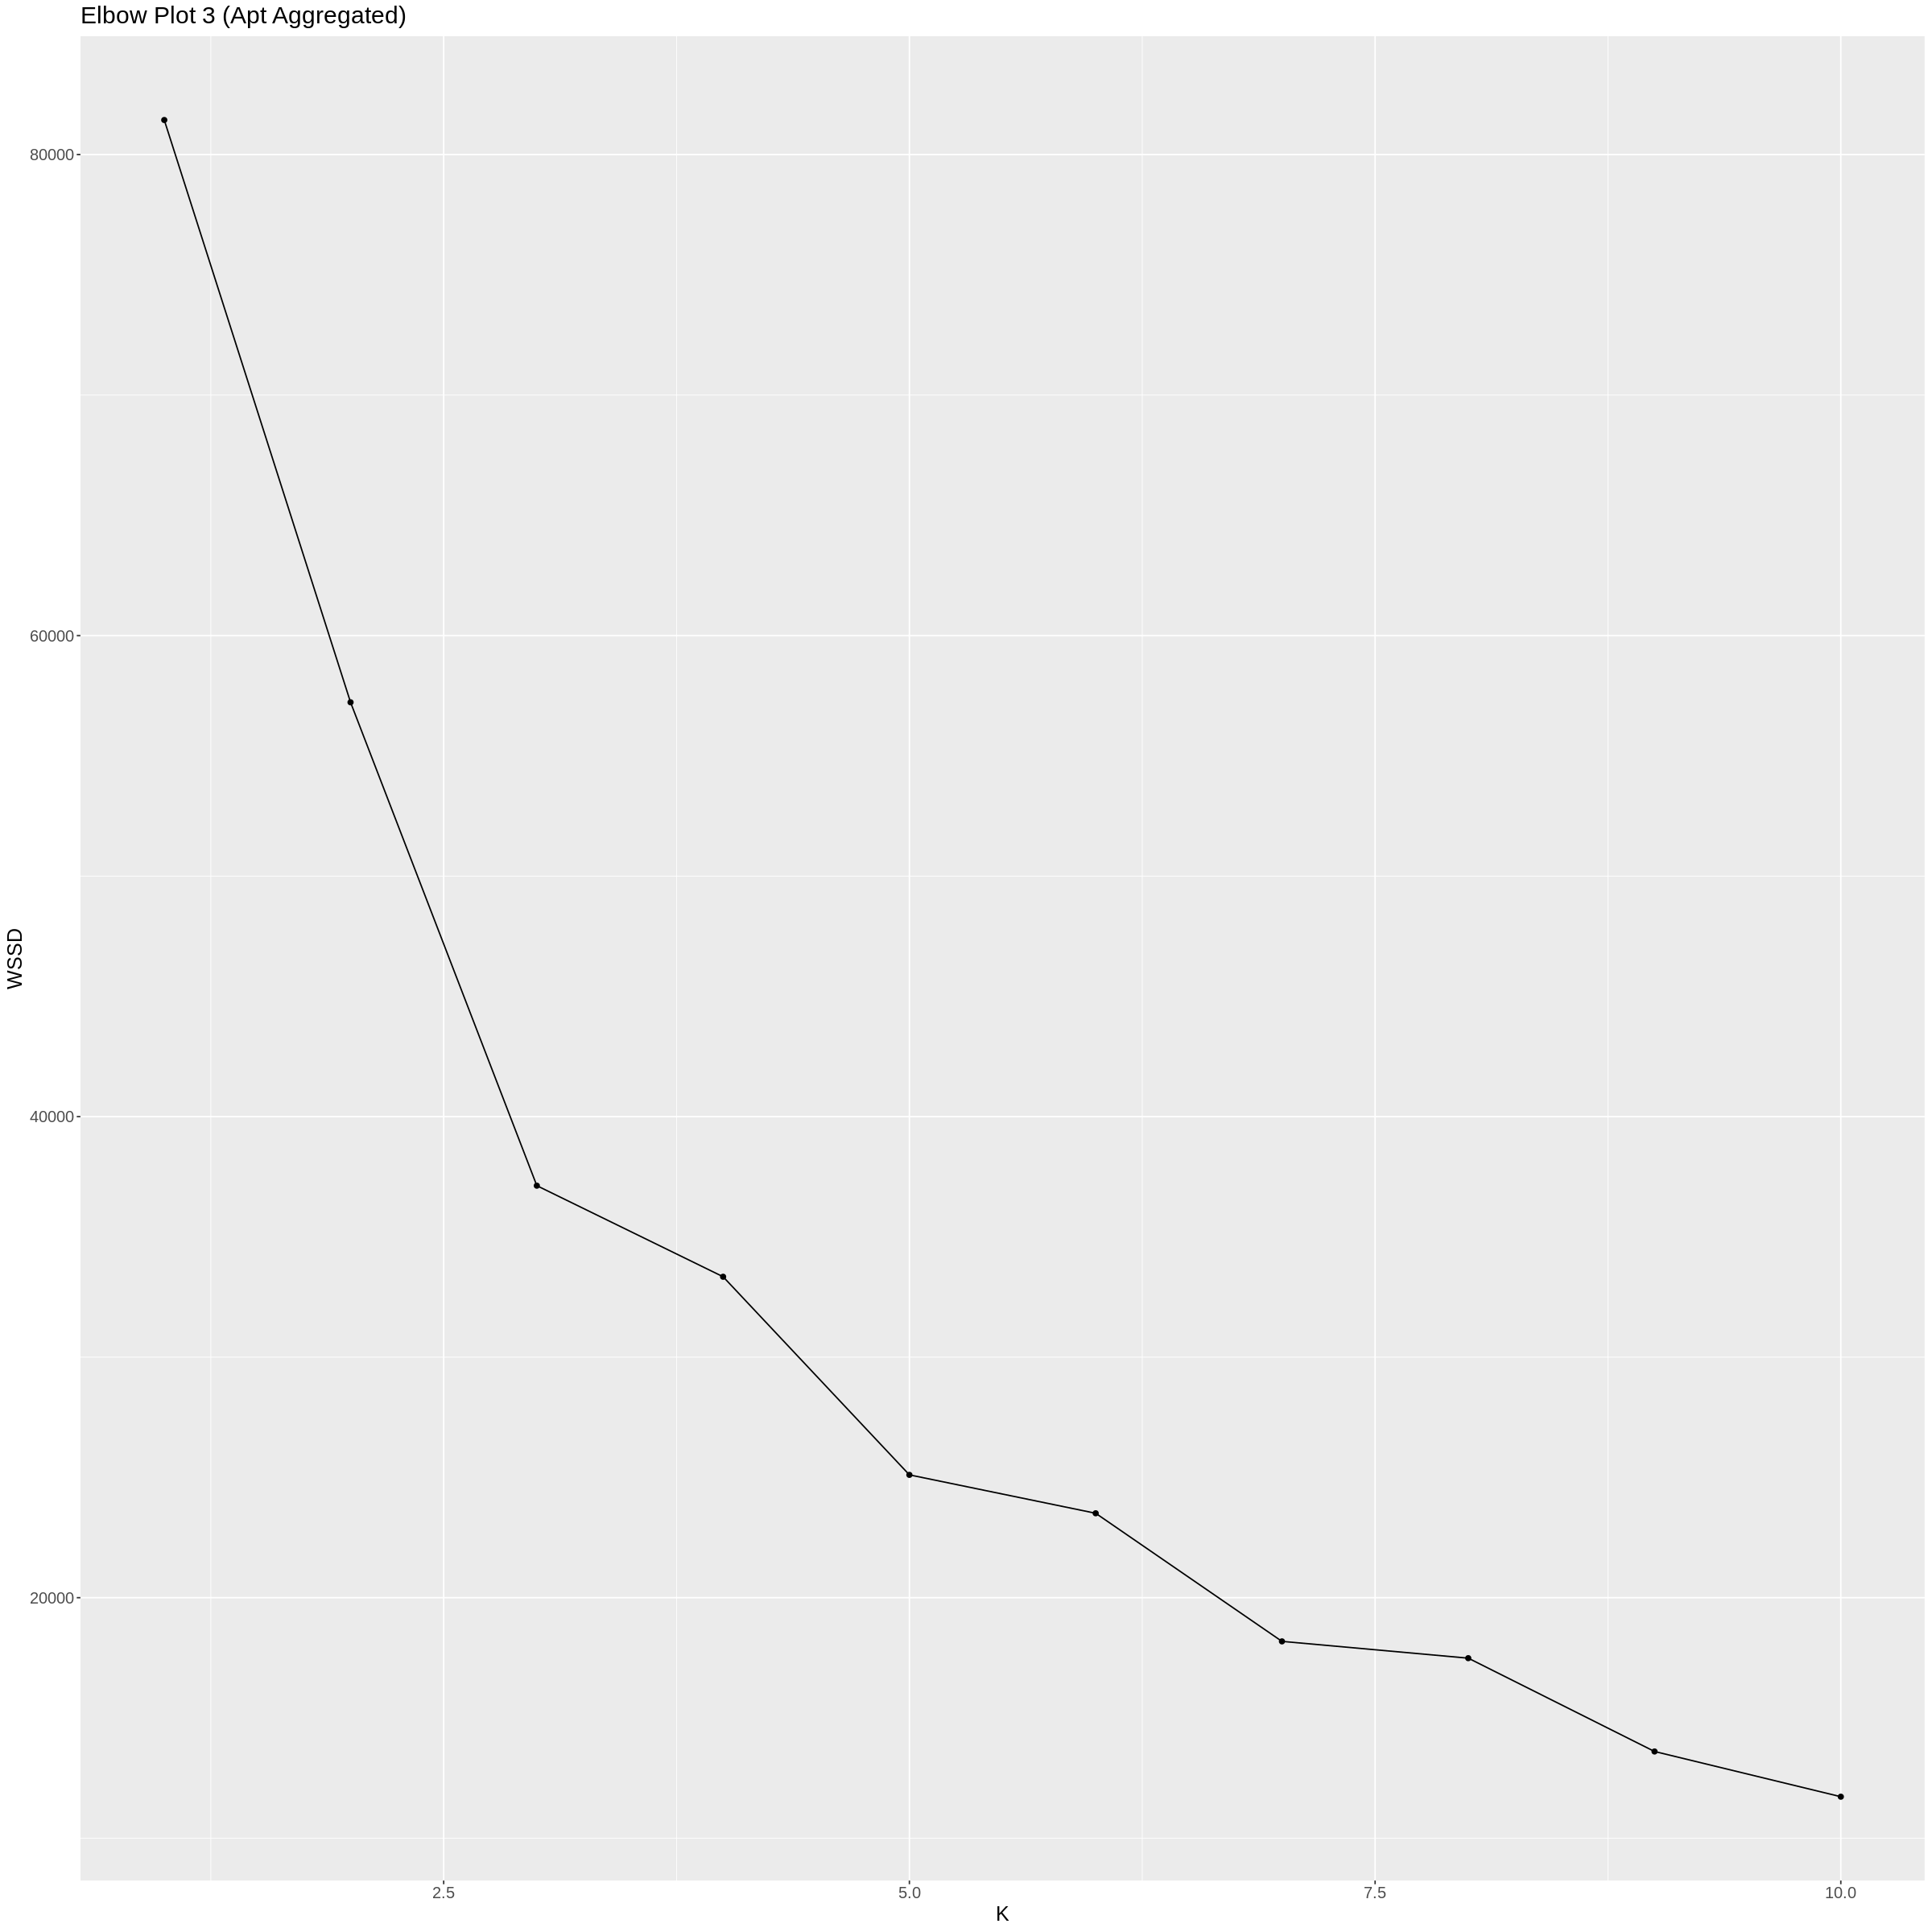

In [121]:
set.seed(9876)
#let's try WITHOUT coordinates
#but with the above knowledge that certain variables correlate strongly with each other in clustering
scaled_property_agg_no_coord <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE,
           MEAN_YEAR_BUILT, MEAN_TAX_LEVY) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_agg_no_coord, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot 3 (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot

AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE MEAN_YEAR_BUILT
1 -0.28258224                  -0.14447684                  0.86637337    
2 -0.03963238                  -0.08136100                  0.14110545    
3  0.09563793                  -0.01838554                 -0.07962826    
4 -0.28258224                  -0.14447684                  0.86637337    
5  0.54690537                   4.95119050                  1.62317468    
6 -0.09575791                  -0.04584552                  0.48797272    
  MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY lat       long       .cluster
1  0.7110076                -0.16343324   -2.029025 -0.4928004 2       
2 -0.3937640                -0.15754334   -1.996884 -0.6221204 2       
3 -0.7299988                 0.02455912   -1.991206 -0.6278243 1       
4  0.7110076                -0.16343324   -1.985125  1.5019575 2       
5  1.8638128                 1.47281958   -1.978267  1.3259091 2       
6  0.1346051                -0.15537106   -1.964202 -0.6576758 2

Warning message:
“Removed 402 rows containing non-finite values (stat_density).”


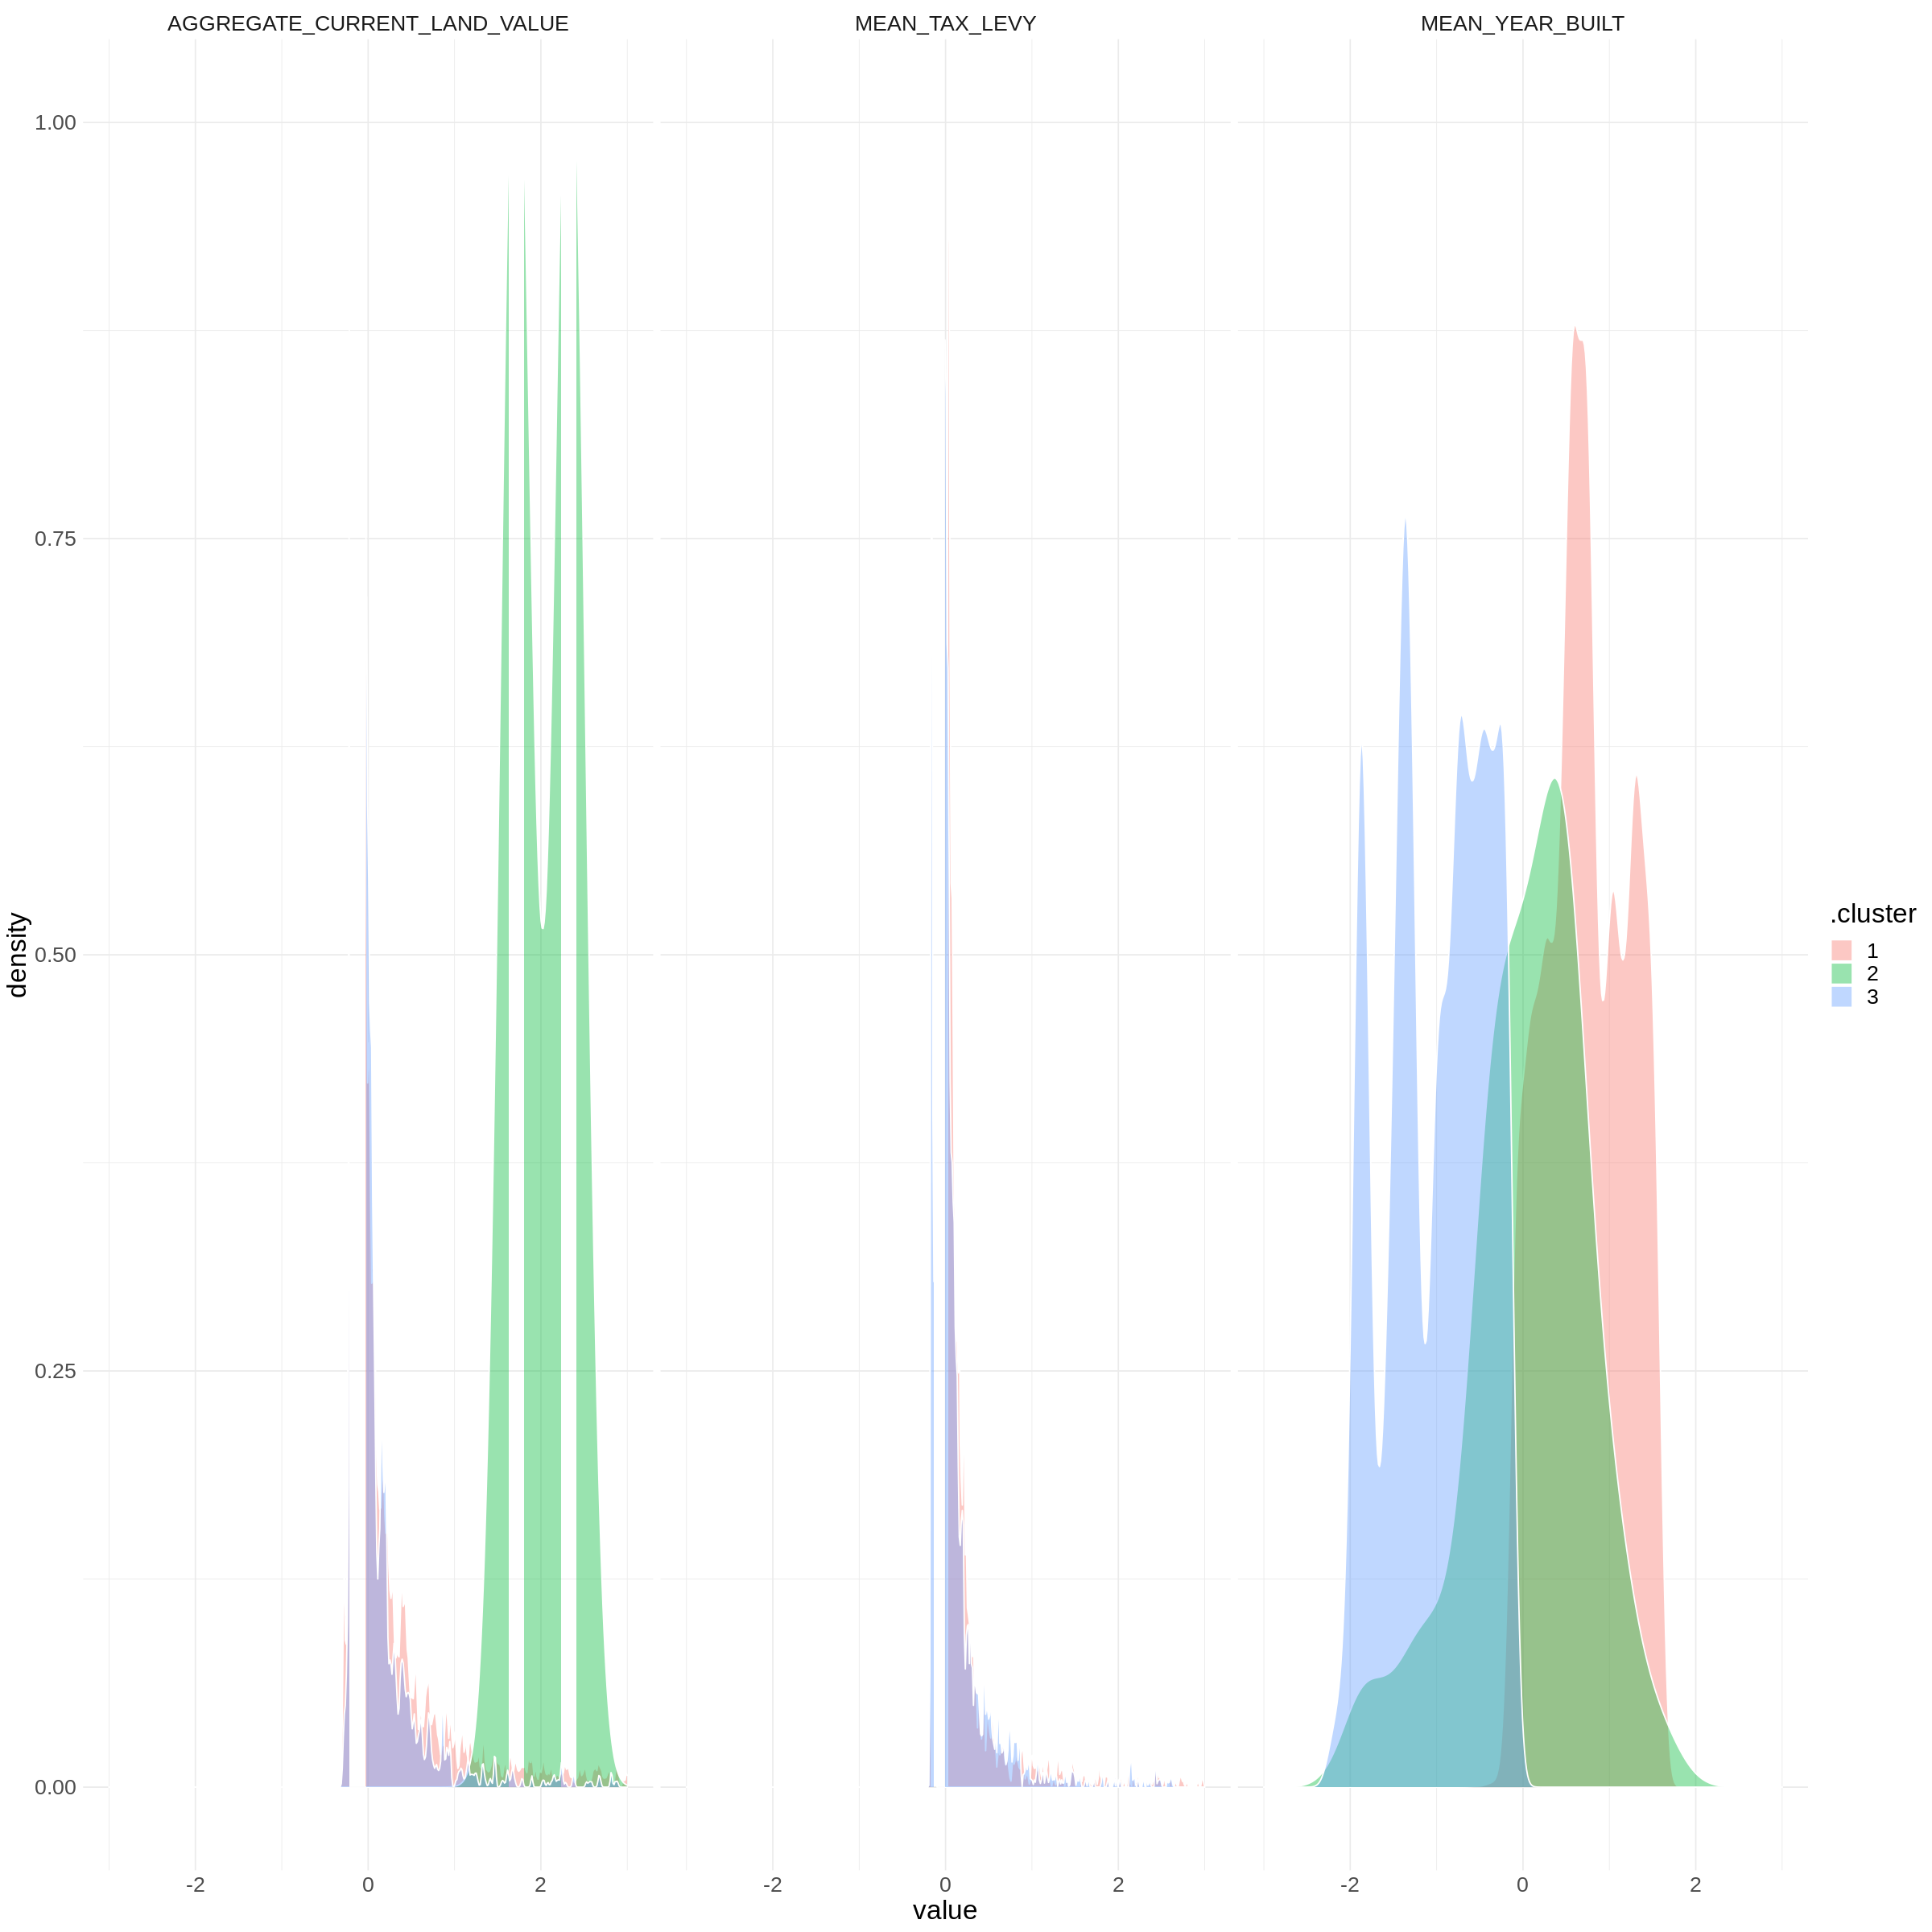

In [123]:
agg_property_clusters_no_coord <- kmeans(scaled_property_agg_no_coord, centers = 3) |>
    augment(scaled_property_agg_no_coord)
head(agg_property_clusters)

variable_dist <- agg_property_clusters_no_coord |>
    pivot_longer(cols = -.cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category)) +
        theme_minimal() +
        theme(text = element_text(size = 20)) +
        xlim(-3, 3) +
        ylim(0, 1)
variable_dist

First, we will narrow down the number of variables to consider. This is because many of the variables included in the data set are representative of similar things, for example "current land value" and "tax levy" could both be used as measures of how much a certain location is worth. Thus, we will first use ggpairs to form a matrix of pairs plots to see how each of the variables correlate with each other. Variables that have a moderately strong correlations will be grouped together, and the anlysis will proceed with only one variable of each group.

lat      long      AGGREGATE_CURRENT_LAND_VALUE AGGREGATE_IMPROVEMENT_VALUE
1 49.20285 -123.0247 33723000                      62400                     
2 49.20317 -123.0267 10053201                       4000                     
3 49.20330 -123.0275  9875399                       4000                     
4 49.20338 -123.1291     2700                       8300                     
5 49.20404 -123.1358  1791000                     327200                     
6 49.20429 -123.0247     2700                       8300                     
  MEAN_YEAR_BUILT MEAN_BIG_IMPROVEMENT_YEAR MEAN_TAX_LEVY SAME_ADDRESS_ENTRIES
1 2003            2003                      215163.000    1                   
2 2005            2005                       56736.200    1                   
3 2005            2005                       55489.800    1                   
4 1998            1998                         489.620    1                   
5 1975            1975                        1178.018    5                   
6 1998            1998                         489.620    1

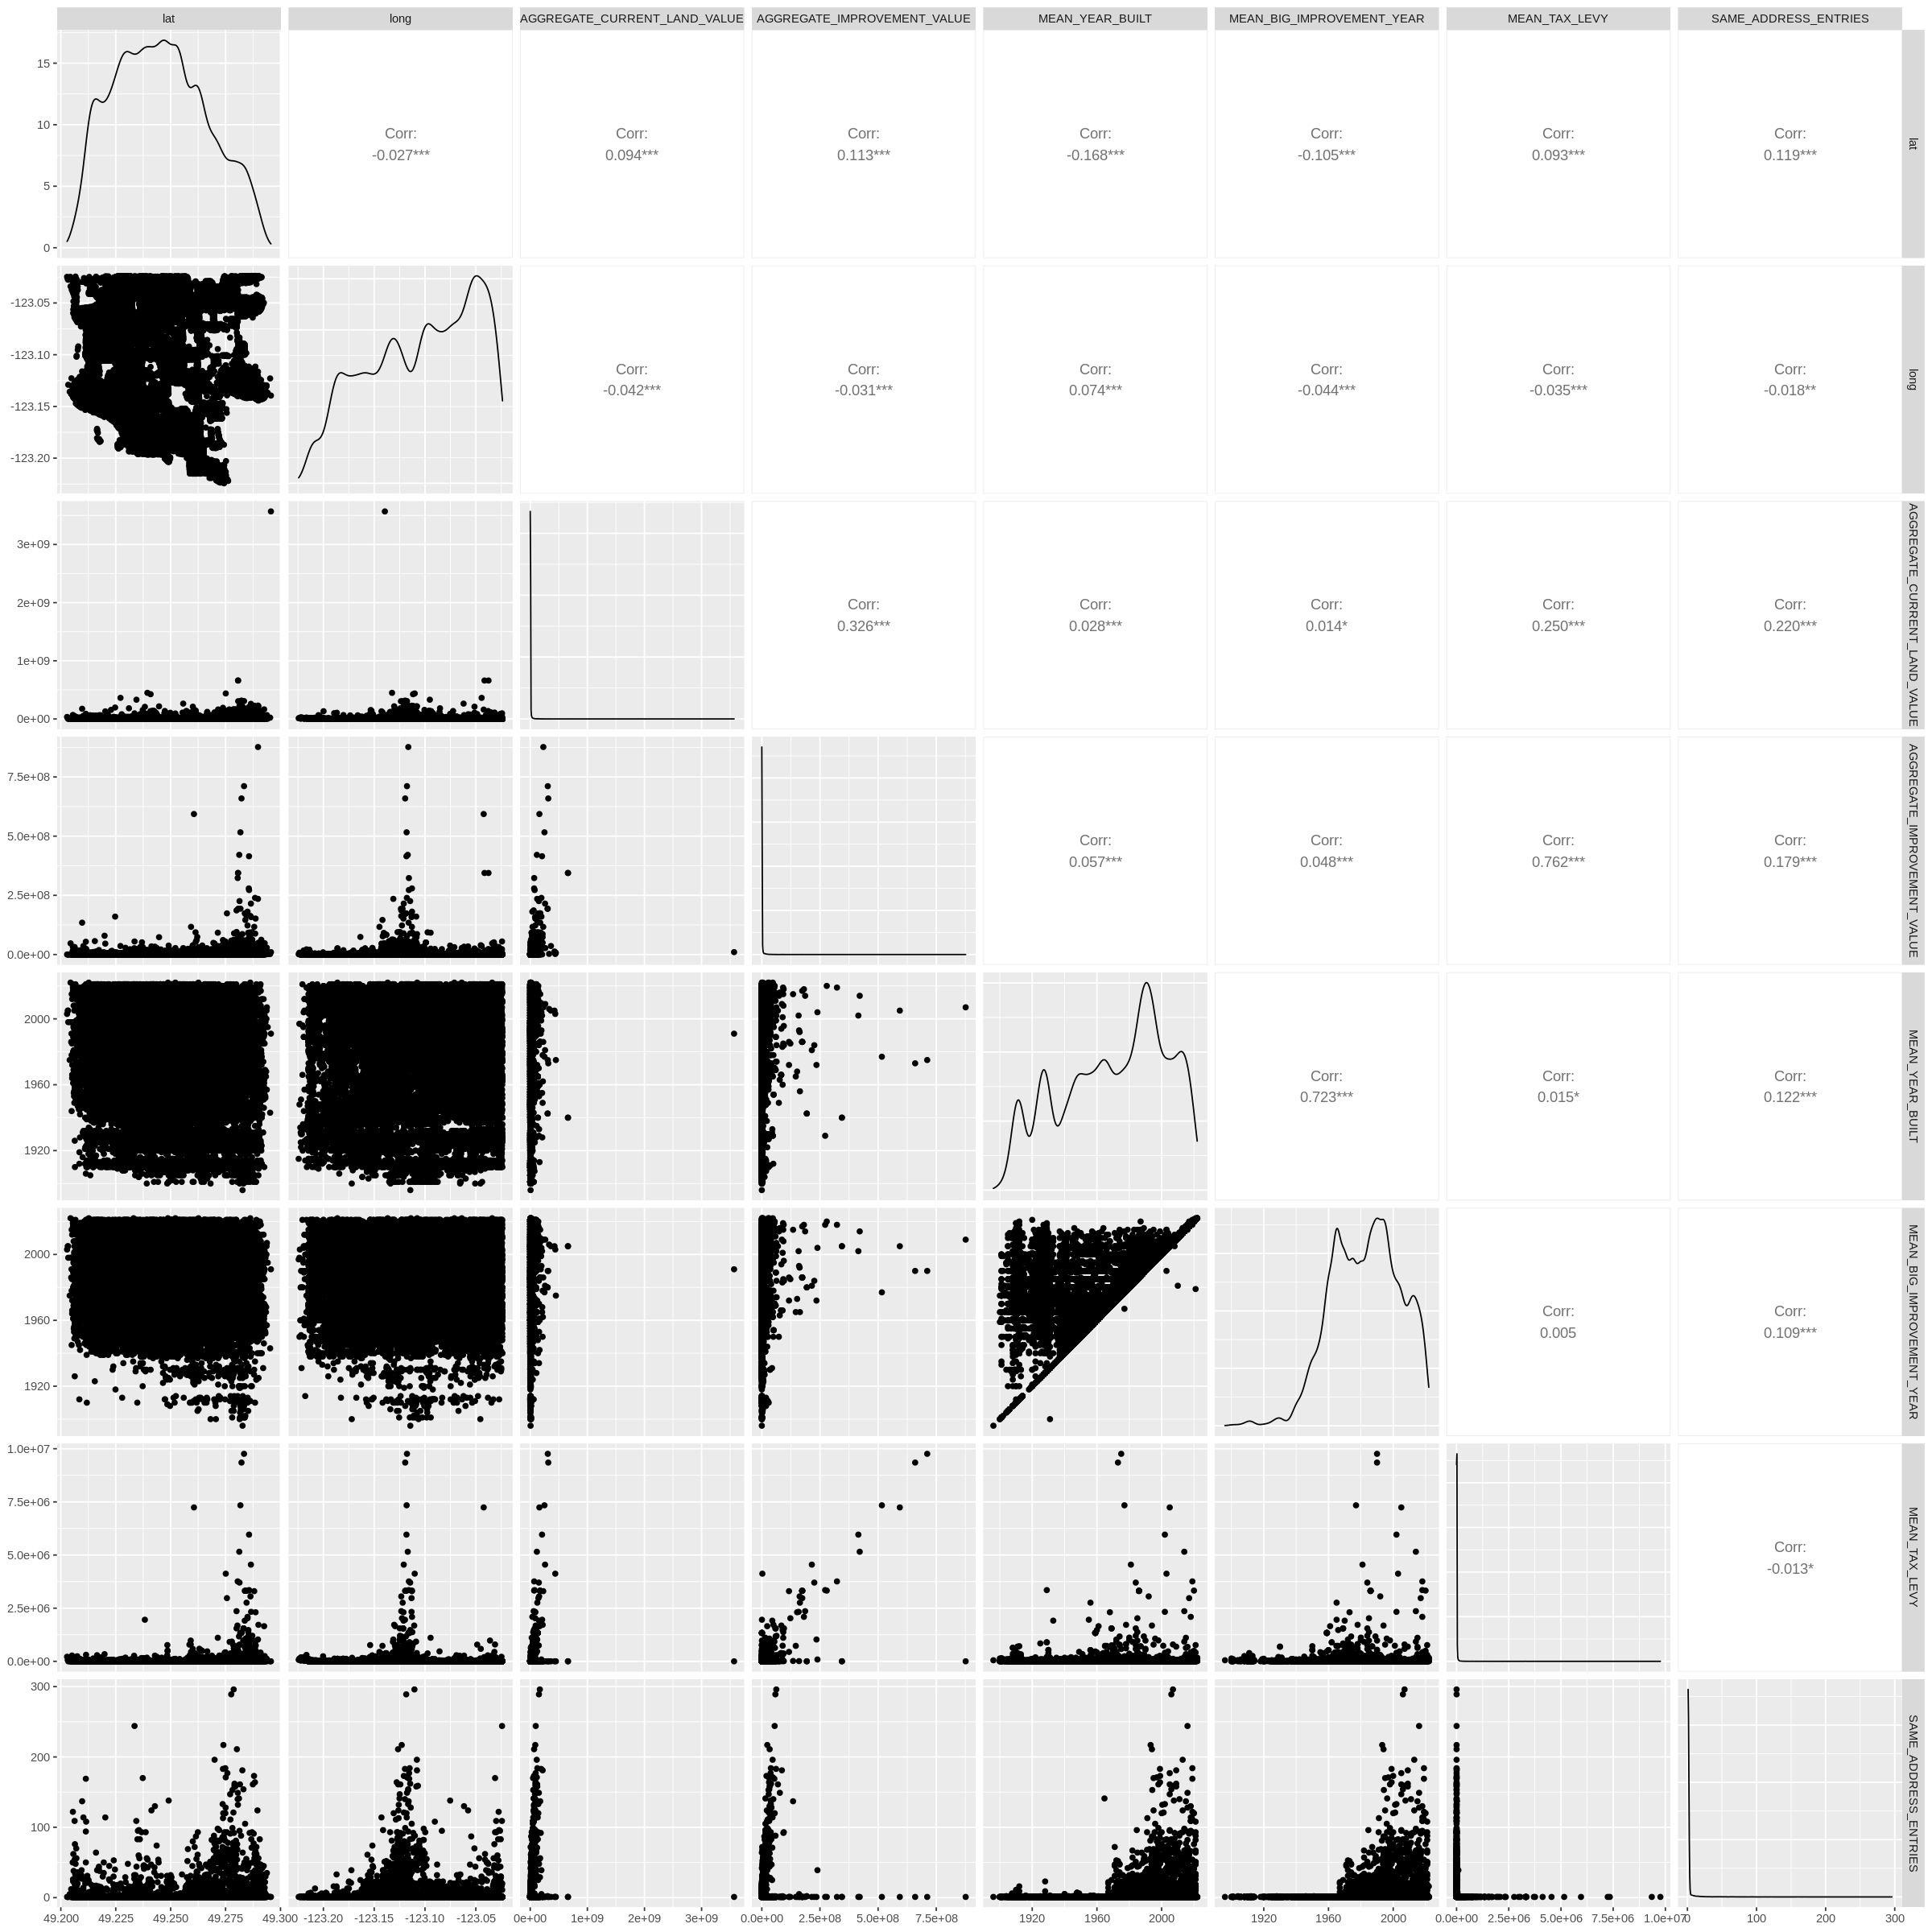

In [7]:
#using ggpairs to find how all the variable correlate with each other
head(housing_aggregated)
ggpairs(housing_aggregated)

Based on the ggpairs plot, year built (MEAN_YEAR_BUILT) and big improvement year (MEAN_BIG_IMPROVEMENT_YEAR) have a strong correlation. In addition, many data points have the same value for year built and big improvement year, since not all buildings had major improvements. Thus, of the two we will proceed with only year built.

Likewaise, current land value (AGGREGATE_CURRENT_LAND_VALUE), current improvement value (AGGREGATE_CURRENT_IMPROVEMENT_VALUE), and tax levy (MEAN_TAX_LEVY) have moderately strong correlations, so we will proceed with only current land value. This will represent the temporal aspect of our analysis.

Latitude (lat) and longitude (long) have very weak correlations with all other variables (and with each other). Both will be kept as the spatial aspect of our analysis.

Variables kept: current land value, year built, latitude, longitude.

Next, we determine the k number of clusters to use in our model by constructing an elbow plot.

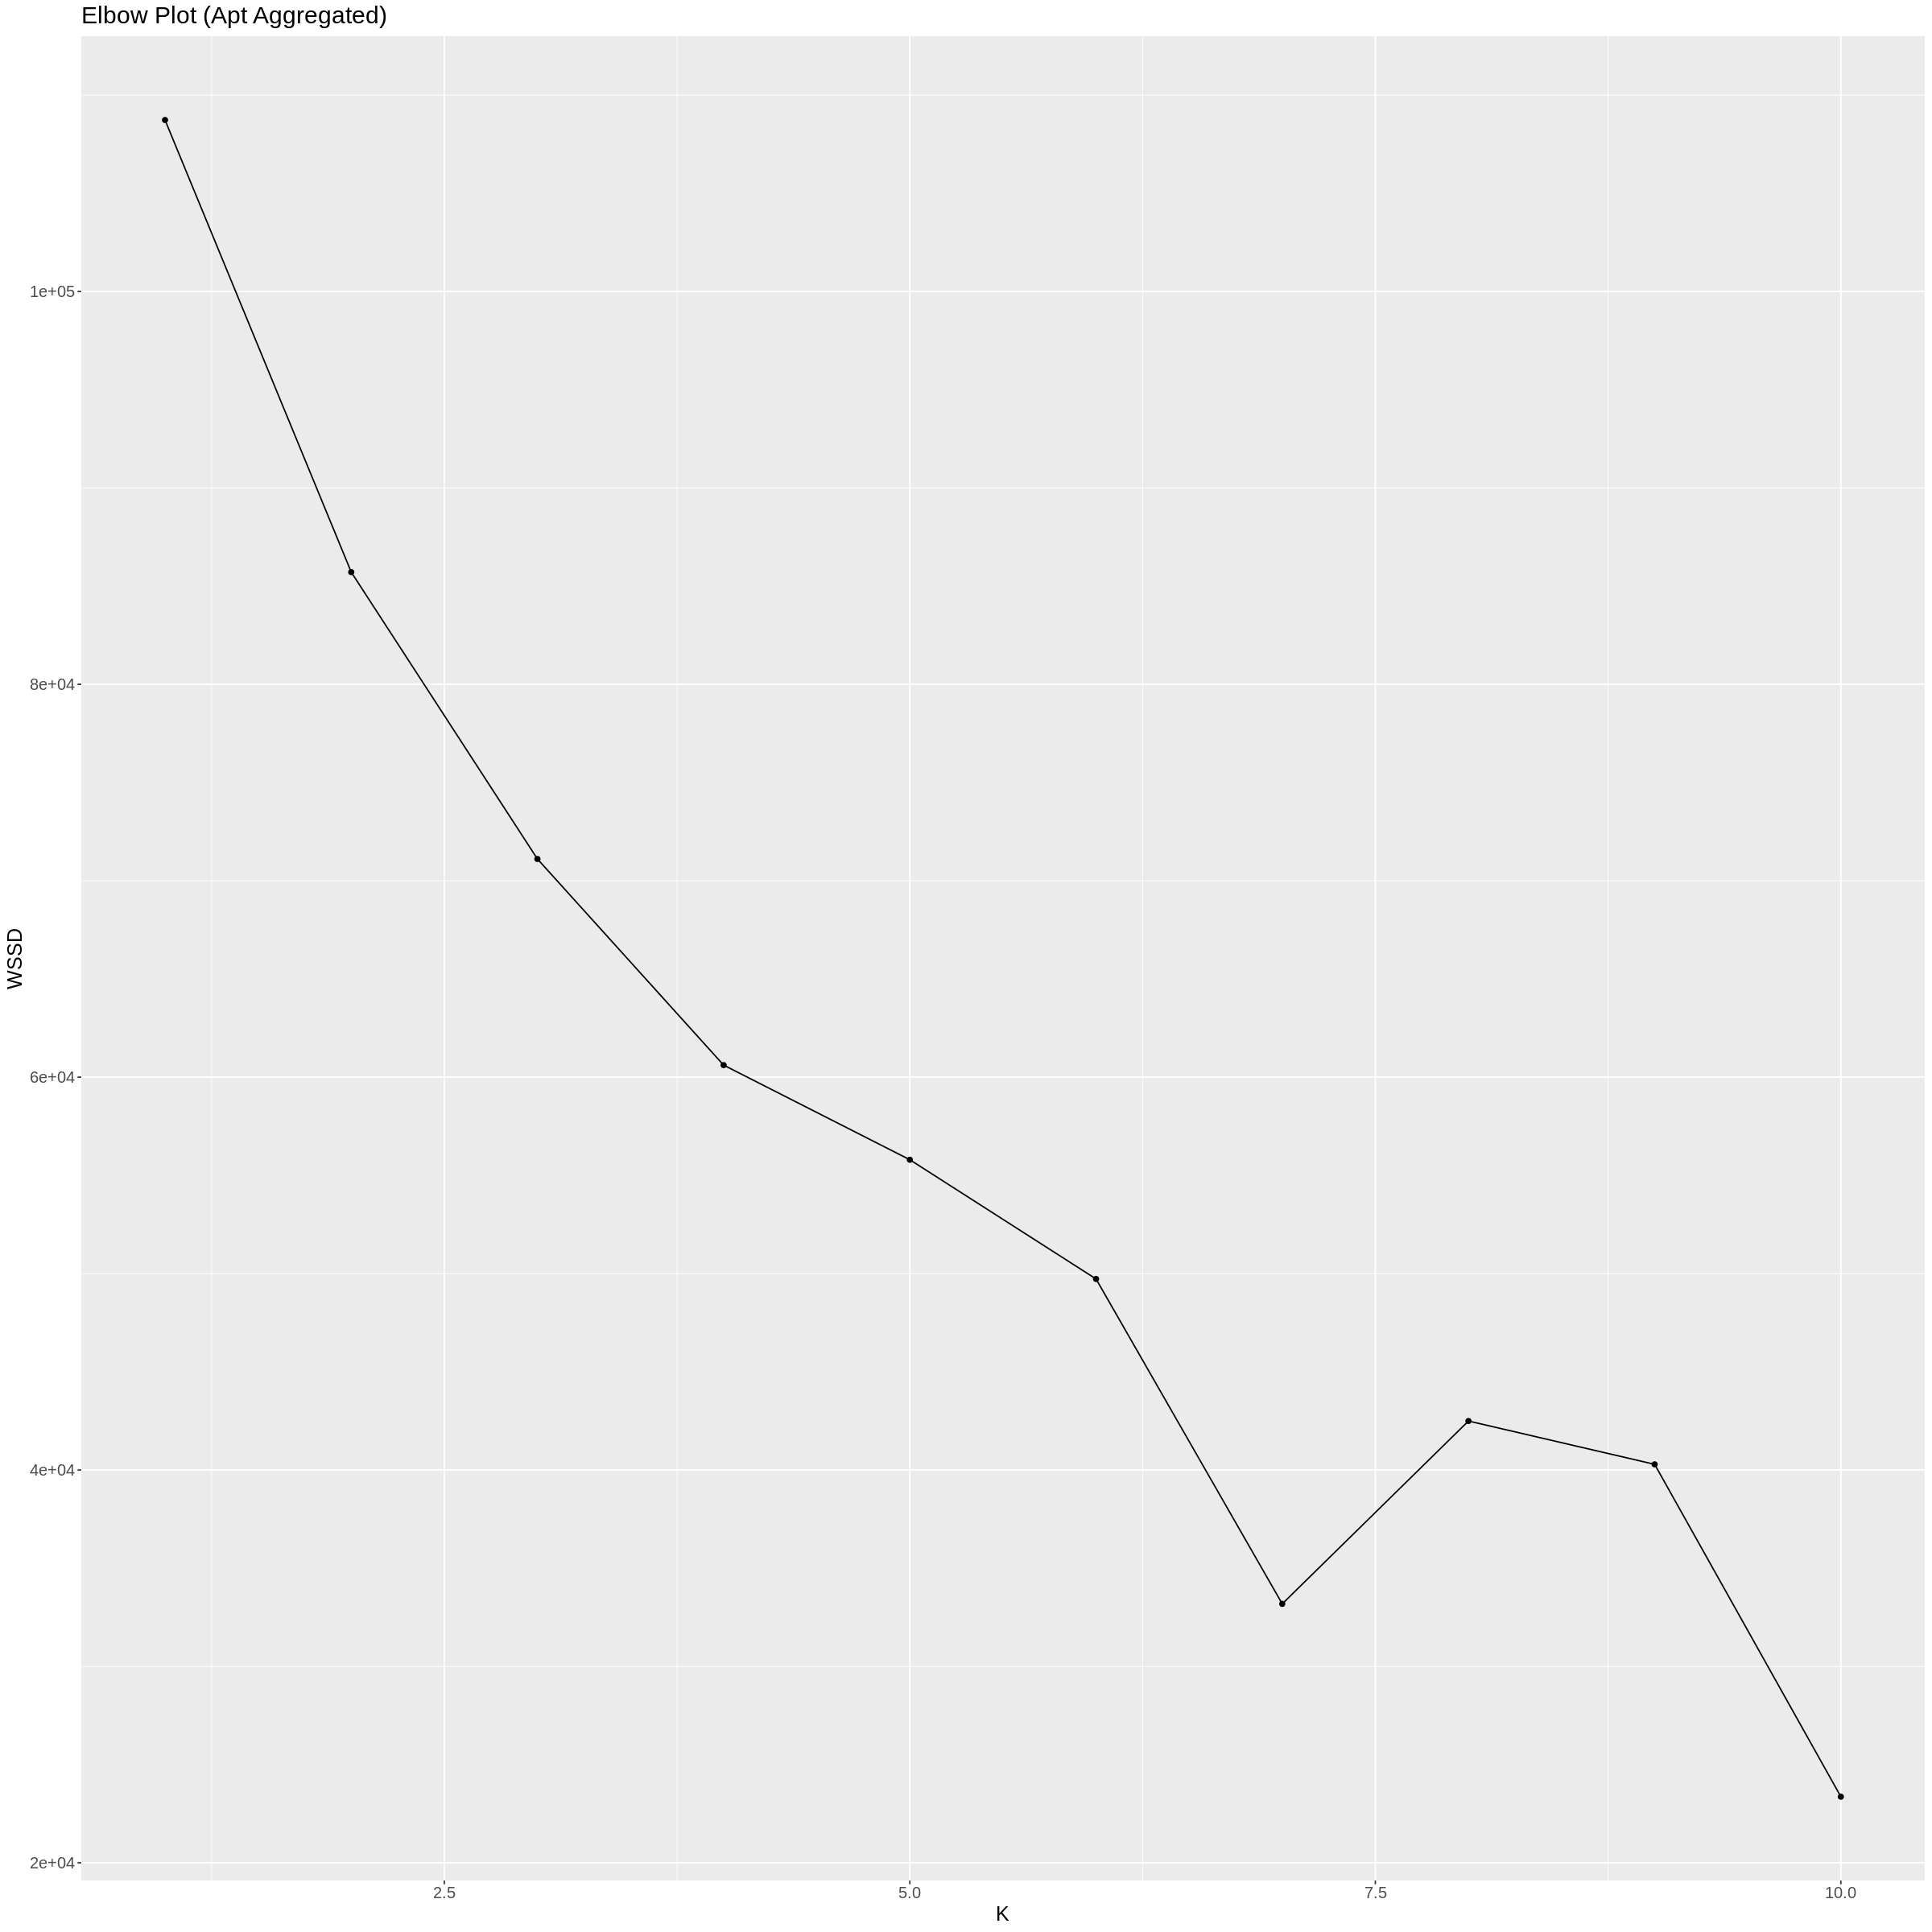

In [17]:
set.seed(9876)

#selecting for variables of interest, then scaling them all
scaled_property_gg <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, MEAN_YEAR_BUILT, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

#gathering the information for the elbow plot to find k
elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_gg, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

#making the elbow plot
elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot (Apt Aggregated)") +
    theme(text = element_text(size = 15))
elbow_plot
#k = 4 or 5 with coords
#k = 3 or 4 without coords

Based on the abovel elbow plot, it appears that k = 4 is the number of clusters that we will proceed with in our analysis. At k = 4, the inflection point of the curve is clearest and beyond that the plot begins going up and down.

Now, we use kmeans to assign each data point to a cluster.

AGGREGATE_CURRENT_LAND_VALUE MEAN_YEAR_BUILT lat       long       .cluster
1  1.1254029                   1.029163        -2.046189  1.5083535 3       
2  0.2135120                   1.092254        -2.030813  1.4708206 3       
3  0.2066620                   1.092254        -2.024309  1.4548501 3       
4 -0.1736887                   0.871435        -2.020802 -0.4930956 3       
5 -0.1047935                   0.145888        -1.988709 -0.6228780 3       
6 -0.1736887                   0.871435        -1.976968  1.5087969 3

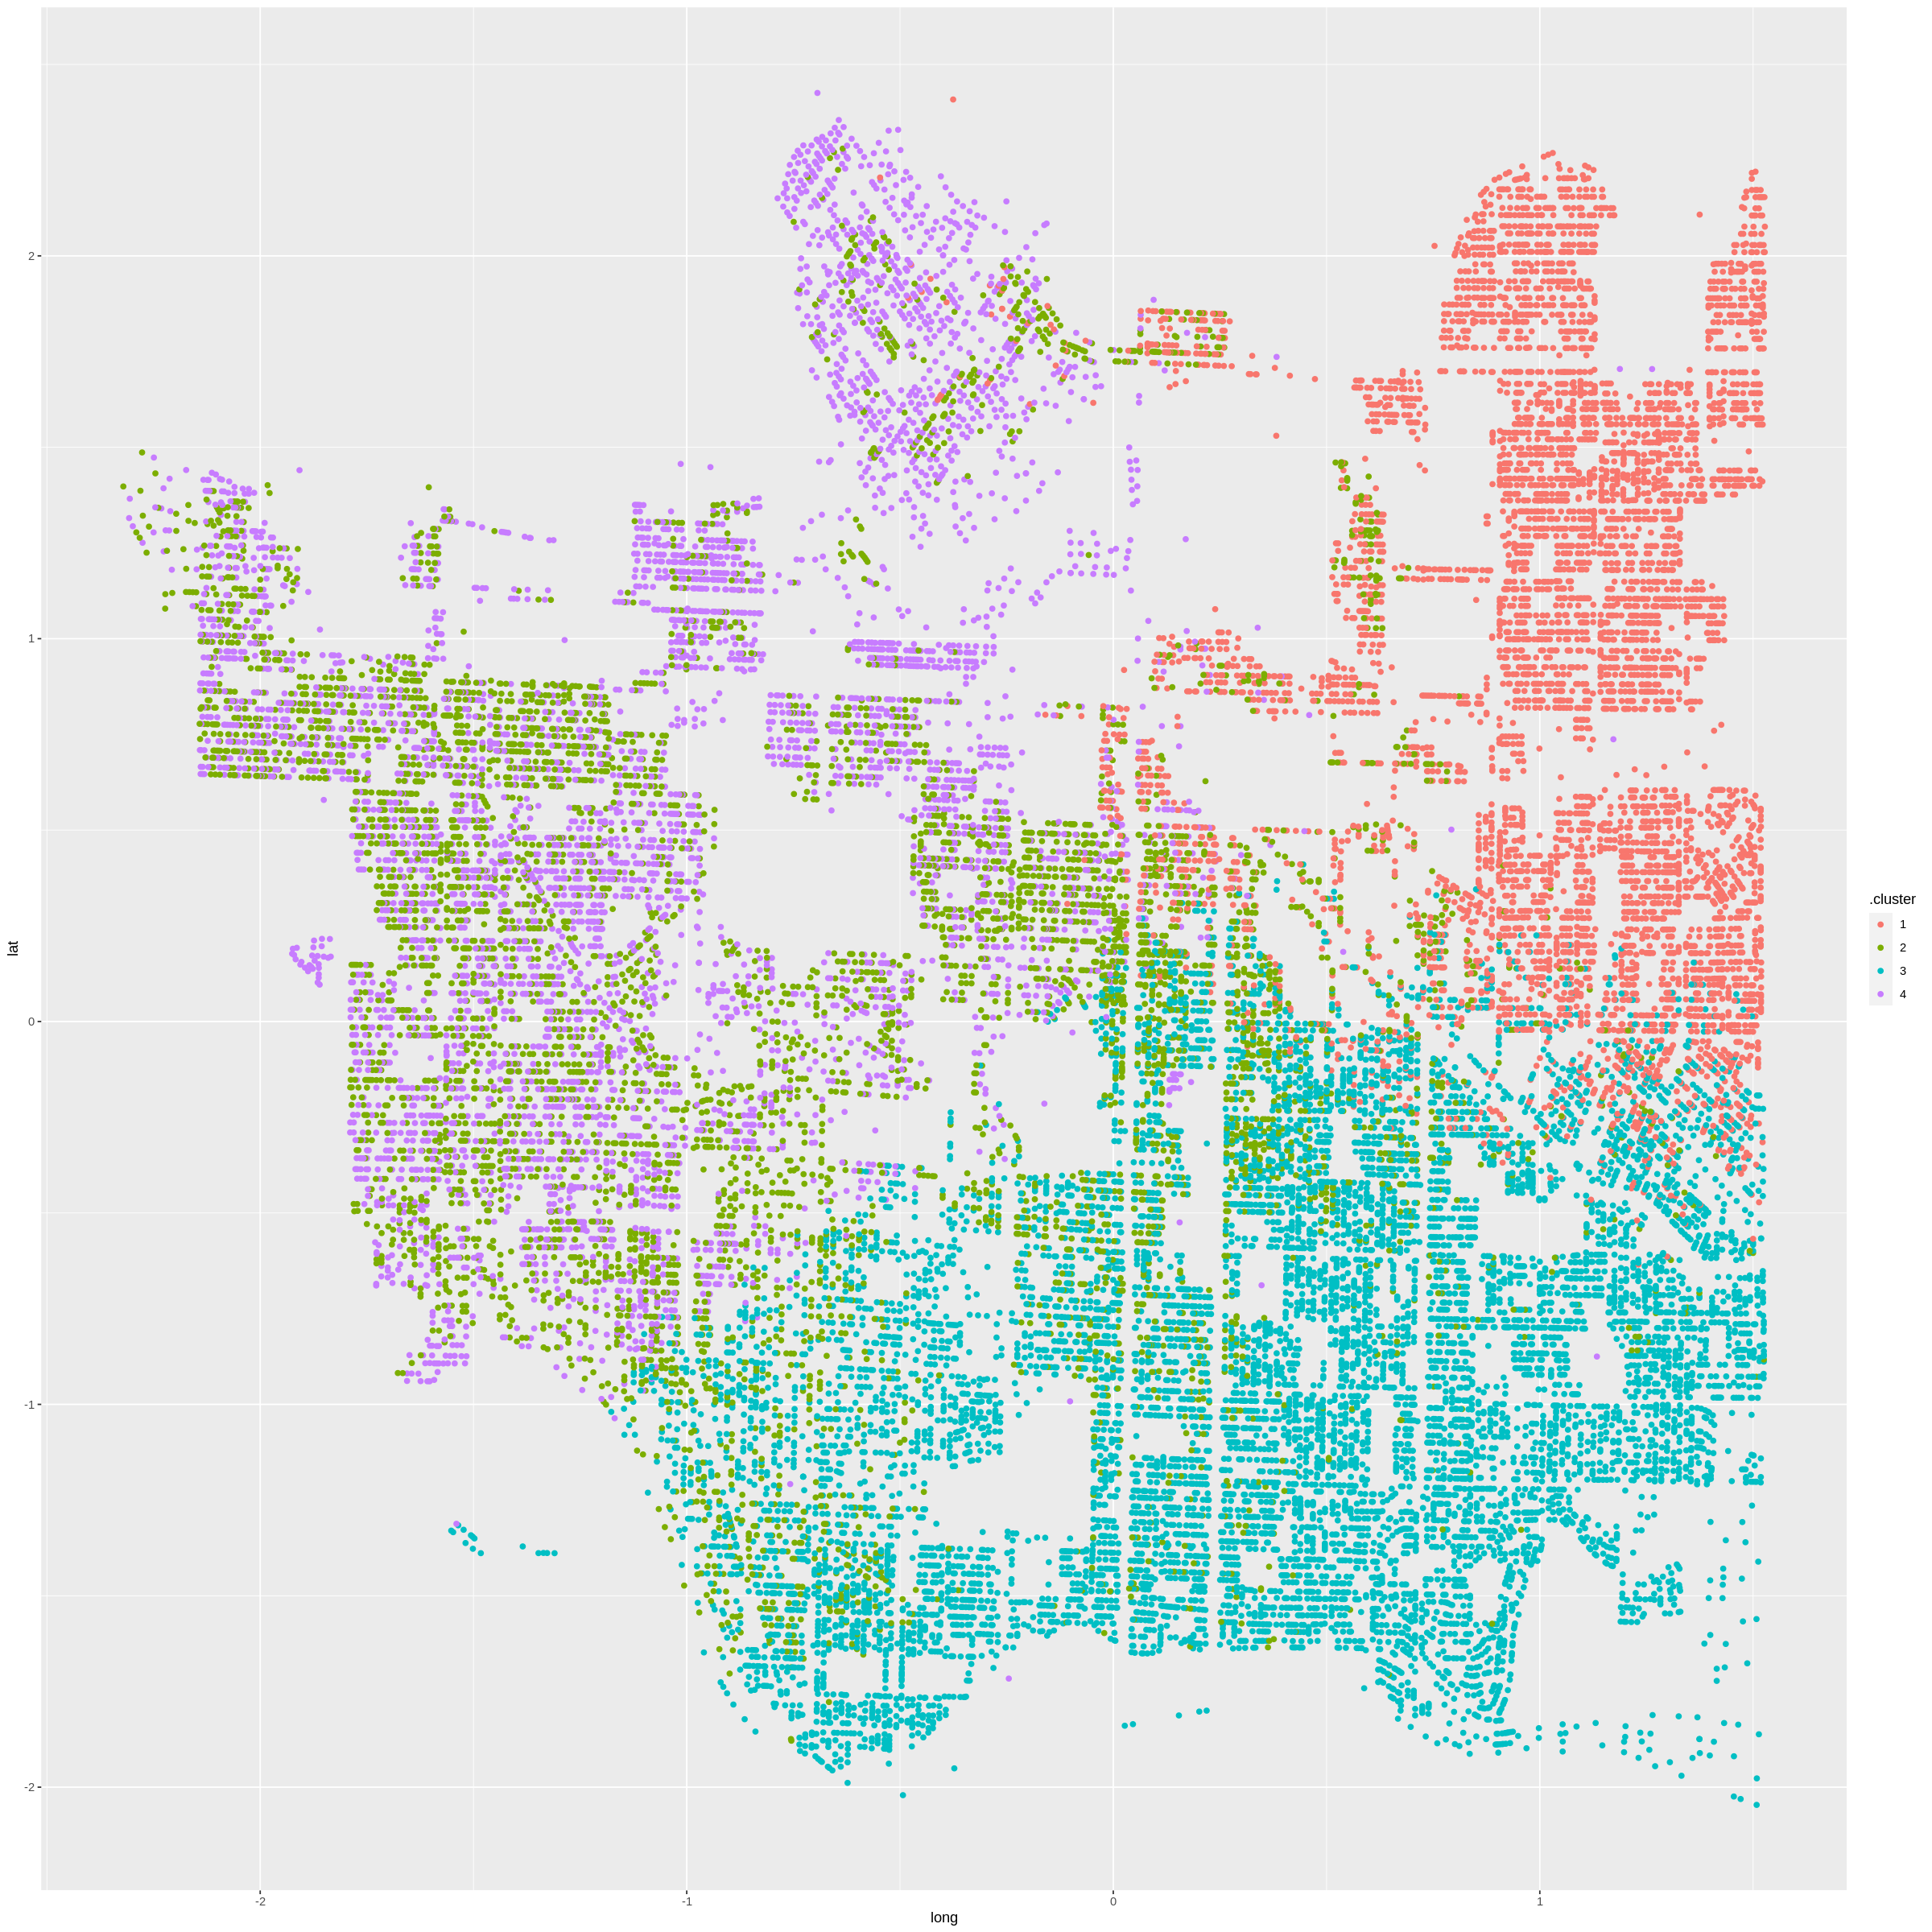

In [19]:
property_clusters <- kmeans(scaled_property_gg, centers = 4) |>
    augment(scaled_property_gg)
head(property_clusters)

property_cluster_plot <- property_clusters |>
    ggplot(aes(x = long, y = lat, color = .cluster)) +
    geom_point()
property_cluster_plot

Warning message:
“did not converge in 10 iterations”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357300)”


MEAN_YEAR_BUILT lat       long       .cluster
1  0.86637337     -2.029025 -0.4928004 4       
2  0.14110545     -1.996884 -0.6221204 4       
3 -0.07962826     -1.991206 -0.6278243 4       
4  0.86637337     -1.985125  1.5019575 4       
5  1.62317468     -1.978267  1.3259091 4       
6  0.48797272     -1.964202 -0.6576758 4

AGGREGATE_CURRENT_LAND_VALUE MEAN_YEAR_BUILT lat       long       .cluster
1     2700                      0.86637337     -2.029025 -0.4928004 4       
2  3760000                      0.14110545     -1.996884 -0.6221204 4       
3  5852000                     -0.07962826     -1.991206 -0.6278243 4       
4     2700                      0.86637337     -1.985125  1.5019575 4       
5 12831000                      1.62317468     -1.978267  1.3259091 4       
6  2892000                      0.48797272     -1.964202 -0.6576758 4

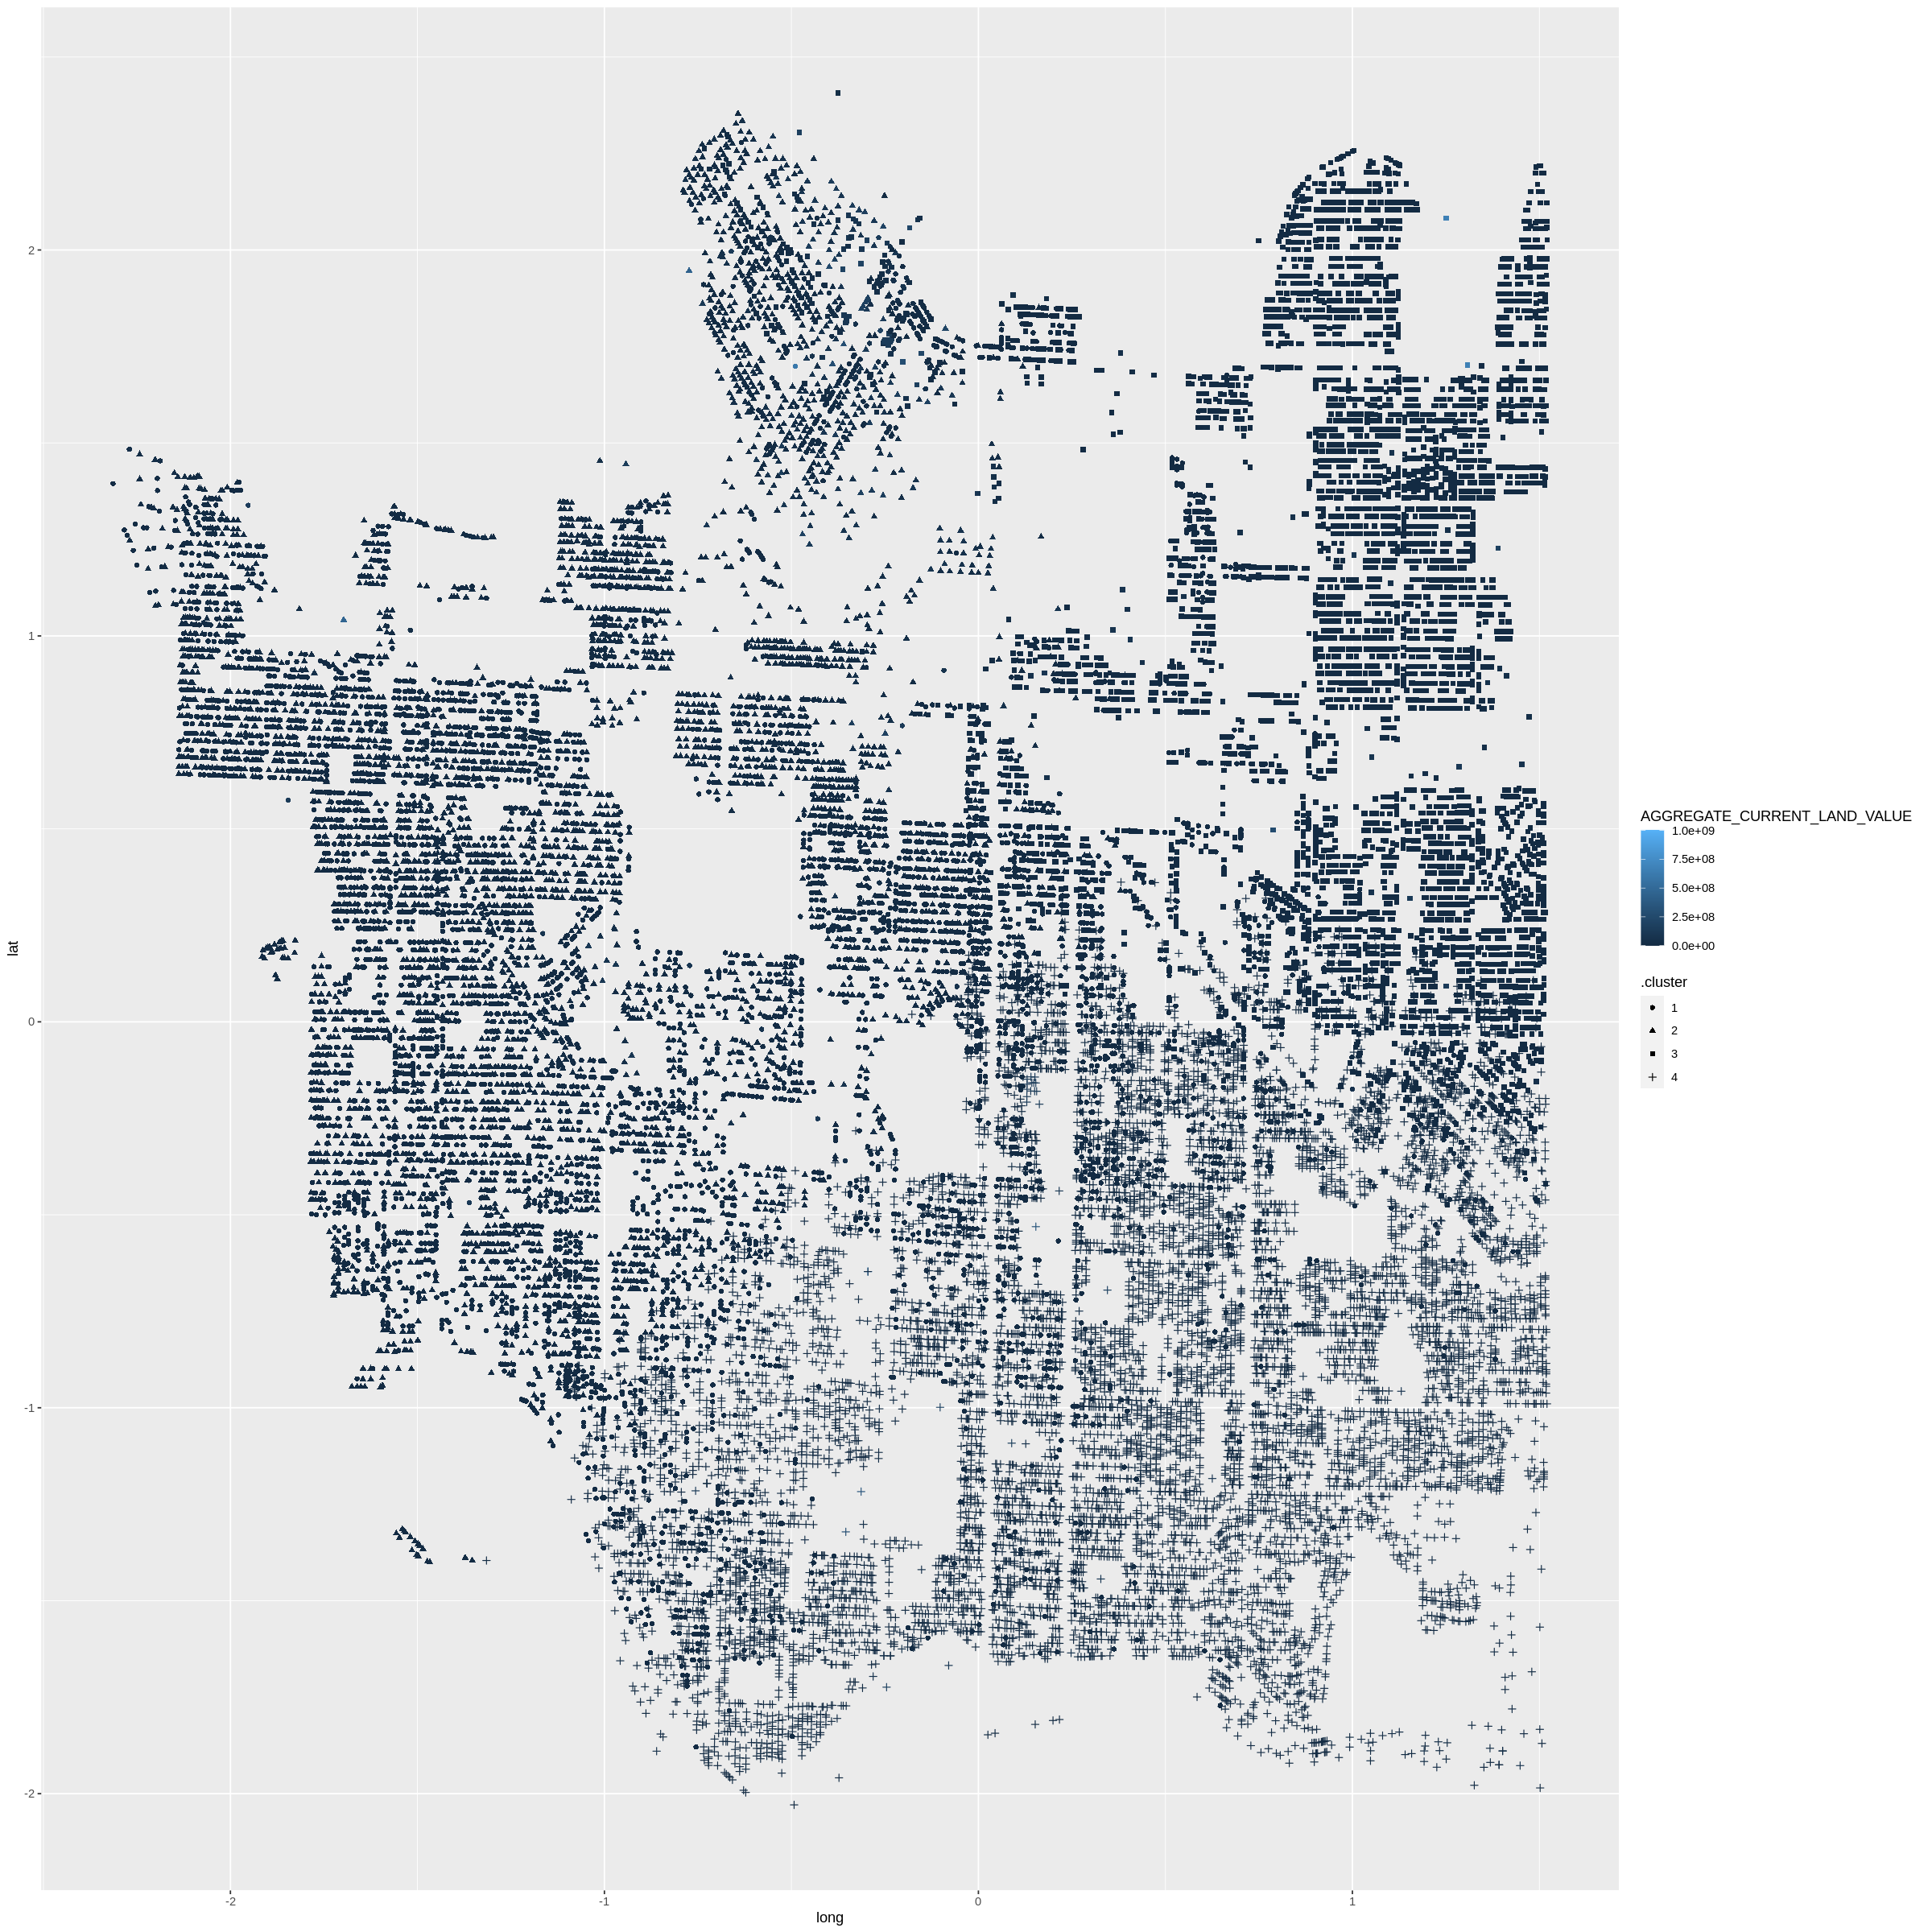

In [34]:
set.seed(9876)
#what if we try predicting current land value based on coordinates and year built?
scaled_property_gg <- housing_aggregated |>
    select(MEAN_YEAR_BUILT, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property_gg, nstart = 10, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot (Apt Aggregated)") +
    theme(text = element_text(size = 15))
# elbow_plot
#k = 4

gg_property_clusters <- kmeans(scaled_property_gg, centers = 4) |>
    augment(scaled_property_gg)
head(gg_property_clusters)

gg_property_bind_cols <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE) |>
    bind_cols(gg_property_clusters)
head(gg_property_bind_cols)

gg_property_plot <- gg_property_bind_cols |>
    ggplot(aes(x = long, y = lat, color = AGGREGATE_CURRENT_LAND_VALUE, shape = .cluster)) +
    geom_point()
gg_property_plot

<h1> 4. Clustering Model </h1>

In [ ]:
# DON'T CHANGE THE SEED VALUE!
set.seed(9876)

<h1> 5. Results Discussion </h1>

<h1> 6. Conclusion </h1>

<h1> 7. References and Resources </h1>